# Pharmacokinetics and Pharmacodynamics of Myelotoxicity

### Contents
- [Introduction](introduction.ipynb)
- [Exploring Data](data_explore.ipynb)
- [PK model - Naive Pooled Inference](PK_naive_pooled_inference.ipynb)
- **PD friberg model - Naive Pooled Inference**
    - [Simulated Data](#Simulated-Data)
        - [Initial Optimisation](#Initial-Optimisation)
    - [Real Data](#Real-Data)

In [5]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
from scipy import optimize, integrate
import pints
import pints.plot
import pandas
import plotly.express as px
import plotly.graph_objects as go

## PD friberg model - Naive Pooled Inference

The first pharmacodynamic model (see [fig 1](PD-Friberg)) we will be looking at was produced by Friberg et. al. which models the life cycle of blood cells as transitioning through different states:

 - a proliferation state ($Prol$), in which the cells are able to proliferate
 - 3 transit states ($T_1$, $T_2$ and $T_3$), which represents the time delay between proliferation and circulation while the cell is maturing
 - a circulation state ($Circ$), in which the cells are circulating the blood stream and can be measured.
 
The blood cells in the proliferation state creates new cells at a rate of $k_{prol}$ when at equilibrium and transitions into the first transition state at a rate of $k_{tr}$. The blood cells also transition from one transition state to the next or from the last transition state into circulation at a rate of $k_{tr}$. The circulating blood cells are cleared from the blood stream at a rate of $k_{circ}$. However, as per the friberg paper, I will simplify the system by making $k_{prol} = k_{tr} = k_{circ} = \frac{4}{\mathrm{MTT}}$ where MTT is the mean transit time. To maintain a concentraion of $Circ$ at a constant level $Circ_0$, there is a negative feedback loop.

The drug interacts with the system by inhibiting proliferation. The relation between drug amount and drug effect is assumed to be linear, i.e. $E_\mathrm{drug} = slope*Conc_\mathrm{drug}$

<img src="Images/PD_Friberg.svg">

This Produces equations:

$$
\dot{Prol} = k_{prol}(1-E_\mathrm{drug})(\frac{Circ_0}{Circ})^\gamma Prol - k_{tr} Prol \\
\dot{T_1} = k_{tr}Prol - k_{tr} T_1\\
\dot{T_2} = k_{tr}T_1 - k_{tr} T_2\\
\dot{T_3} = k_{tr}T_2 - k_{tr} T_3\\
\dot{Circ} = k_{tr}T_3 - k_{tr} Circ
$$

### Simulated Data

I initially test fit the model to simulated data before trying to fit to the real data. This shows which methods can reliably infer the parameters. The noise used had both additive and multiplicative parts, i.e.
$$
X_\mathrm{Obs}(t_i) = Circ(t_i) + \left(\sigma_{base} + \sigma_{rel} Circ(t_i)^\eta\right) \epsilon_i,
$$
where 
$$
\epsilon_i \sim \mathcal{N}\left(0,\,\sigma^{2}\right)
$$
I used the typical PD parameters that Friberg et. al. inferred to create this synthesised data. The PK parameters came from the previous inference that I performed for Docetaxel. This dataset has 100 observations between the times -48 hours and 1440 hours (where dosing occurs at 0 hours).

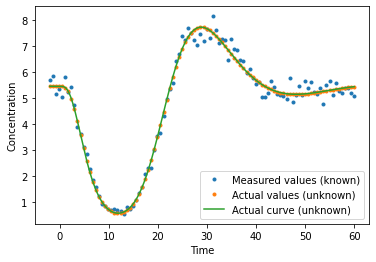

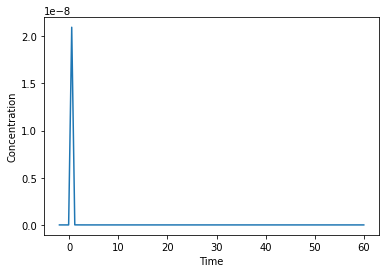

In [6]:
from ipynb.fs.full.model_simulation import PK_iv_result # import the required model
from ipynb.fs.full.model_simulation import PD_result # import the required model

# Options
drug = 'Simulated Drug'
dose = 2

# Retrieve the parameters for the conc-time curve
PK_params = np.load('simulated_parameters_actual_dose'+str(dose)+'.npy')
num_comp = int(len(PK_params)/2)  # If this has a linear PK model


# Actual Parameters - Taken from the Friberg Paper
# (This is only to produce the simulated data. These are 'unknown' when doing the inference)
Circ_0 = 5.45
MTT = 135
gamma = 0.174
slope = 0.126
PD_actual_params = [Circ_0, MTT, gamma, slope]
param_names = ["Circ_0", "MTT", "gamma", "slope"]

# Create the Data
start_time = -48
end_time = 1440
num_obs = 100
data_times = np.linspace(start_time, end_time, num_obs)
# data_times = [-48, ] 
# Uncomment the above line if you want the simulated data to mimic the real data
times_before_dose = np.count_nonzero(data_times < 0)

# Conc-Time Curve
PK_times = data_times[times_before_dose:]
if PK_times[0] == 0:
    conc_cuve = PK_iv_result(dose, num_comp, PK_params, PK_times)[:,0]
    conc_cuve = np.concatenate((np.zeros(times_before_dose), conc_curve))
else:
    conc_curve = PK_iv_result(dose, num_comp, PK_params, np.concatenate((np.zeros(1),PK_times)))[:, 0]
    conc_curve = np.concatenate((np.zeros(times_before_dose), conc_curve[1:]))

mult_noise = np.random.normal(0, 0.453*0.1, len(data_times))
add_noise = np.random.normal(0, 0.671*0.1, len(data_times))
values_no_noise = PD_result(dose, num_comp, np.concatenate((PK_params, np.asarray(PD_actual_params))), data_times)
values_noisey = values_no_noise*(1+mult_noise)+add_noise
df = pandas.DataFrame({'TIME' : data_times, 'OBS' : values_noisey})

more_times = np.linspace(start_time, end_time, num_obs*10)
more_values = PD_result(dose, num_comp, np.concatenate((PK_params, np.asarray(PD_actual_params))), more_times)

# Visualise the data
plt.plot(df['TIME']/24, df['OBS'], '.', label='Measured values (known)')
plt.plot(data_times/24, values_no_noise, '.', label='Actual values (unknown)')
plt.plot(more_times/24, more_values, label='Actual curve (unknown)')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

plt.plot(data_times/24, conc_curve)
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show

np.save("./Data_and_parameters/pd_sim_actual_params_dose_"+str(dose), PD_actual_params)

In [10]:
# save the data for ease of use later
data_file = "./Data_and_parameters/pd_sim_data_dose_" + str(dose)
df.to_csv(data_file, index = False)

#### Initial Optimisation

Before performing bayesian inference, I used optimisation to find the parameters with the highest likelihood, given the data. This should give a good starting point for using bayesian inference 

In [8]:
from ipynb.fs.full.model_simulation import ConstantAndMultiplicativeGaussianLogLikelihood # import the liklihood
from ipynb.fs.full.model_simulation import PintsPDFriberg # import the pints model

# Create the model in PINTS 
dose = 2
PK_params=np.load('simulated_parameters_actual_dose'+str(dose)+'.npy')
df = pandas.read_csv("./Data_and_parameters/pd_sim_data_dose_" + str(dose))
pints_model_simulated = PintsPDFriberg(PK_params, dose, start_time=start_time)

In [9]:
# Before starting the optimisation we should estimate the parameter Circ_0. We can do this by averaging over all 
# the values before time 0
df_before_0 = df[df["TIME"] < 0]
Circ_0_approx = sum(df_before_0["OBS"])/times_before_dose
print("approximate Circ_0: ", Circ_0_approx)

approximate Circ_0:  5.509023911078759


In [10]:
# Optimise the model with respect to the data by maximising the Log Likelihood.
problem = pints.SingleOutputProblem(pints_model_simulated, df['TIME'].to_numpy()-start_time, df['OBS'].to_numpy())
log_likelihood = ConstantAndMultiplicativeGaussianLogLikelihood(problem)
error_measure = pints.ProbabilityBasedError(log_likelihood)
lower_bound = [1e-2, 1e0, 1e-3, 1e-3, 1e-4, 1e-2, 1e-4]
upper_bound = [1e2, 1e4, 1e1, 1e1, 1e2, 1e2, 1e2]

point1 = np.exp((np.log(np.asarray(lower_bound)) + np.log(np.asarray(upper_bound)))/2 + 1)
point2 = np.exp((np.log(np.asarray(lower_bound)) + np.log(np.asarray(upper_bound)))/2)
point3 = np.exp((np.log(np.asarray(lower_bound)) + np.log(np.asarray(upper_bound)))/2 -1)
point1[0], point2[0], point3[0] = Circ_0_approx, Circ_0_approx, Circ_0_approx
unchanged_threshold = 1e-4

optimisation1 = pints.OptimisationController(error_measure, point1, method=pints.CMAES, boundaries=pints.RectangularBoundaries(lower_bound, upper_bound))
optimisation1.set_max_unchanged_iterations(threshold=unchanged_threshold)

optimisation2 = pints.OptimisationController(error_measure, point2, method=pints.CMAES, boundaries=pints.RectangularBoundaries(lower_bound, upper_bound))
optimisation2.set_max_unchanged_iterations(threshold=unchanged_threshold)

optimisation3 = pints.OptimisationController(error_measure, point3, method=pints.CMAES, boundaries=pints.RectangularBoundaries(lower_bound, upper_bound))
optimisation3.set_max_unchanged_iterations(threshold=unchanged_threshold)

optimisation1.set_log_to_screen(True)

parameterslike1, errorlike1 = optimisation1.run()
parameterslike2, errorlike2 = optimisation2.run()
parameterslike3, errorlike3 = optimisation3.run()
actual_error = error_measure(PD_actual_params)
parameterslike = [parameterslike1, parameterslike2, parameterslike3, [errorlike1,  errorlike2,  errorlike3, actual_error]]

np.save("./Data_and_parameters/pd_sim_opt_like_params_dose_"+str(dose), parameterslike)

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 9
Iter. Eval. Best      Time m:s
0     9      998.3182   0:01.8
1     18     998.3182   0:03.6
2     27     998.3182   0:05.2
3     36     998.3182   0:07.1
20    189    866.3869   0:34.5
40    369    554.6894   1:05.4
60    549    535.9121   1:34.7
80    729    515.3819   2:03.4
100   909    500.372    2:34.5
120   1089   473.0956   3:05.4
140   1269   466.8581   3:35.4
160   1449   454.8529   4:06.5
180   1629   367.7878   4:35.2
200   1809   297.2487   4:58.9
220   1989   288.798    5:24.0
240   2169   287.1622   5:56.0
260   2349   285.7335   6:27.8
280   2529   281.6623   6:59.6
300   2709   278.901    7:31.9
320   2889   275.4053   8:04.1
340   3069   265.1425   8:35.5
360   3249   254.1726   9:05.2
380   3429   244.3243   9:34.0
400   3609   232.5673  10:01.7
420   3789   223.392   10:28.1
440   3969   207.4817  10:50.2
460   4149   199.6811  11:09

/home/rumney/Documents/Myleotoxicity/pkpdapp/env/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [12]:
# Optimise the model with respect to the data
problem = pints.SingleOutputProblem(pints_model_simulated, df['TIME'].to_numpy()-start_time, df['OBS'].to_numpy())
error_measure = pints.SumOfSquaresError(problem)
lower_bound = [0.01, 0.1, 0.01, 0.001]
upper_bound = [100, 1000, 100, 10]

point1 = np.asarray(lower_bound) + (np.asarray(upper_bound) - np.asarray(lower_bound))/4
point2 = (np.asarray(lower_bound) + np.asarray(upper_bound))/2
point3 = np.asarray(lower_bound) + 3*(np.asarray(upper_bound) - np.asarray(lower_bound))/4
point1[0], point2[0], point3[0] = Circ_0_approx, Circ_0_approx, Circ_0_approx
unchanged_threshold = 1e-4

optimisation1 = pints.OptimisationController(error_measure, point1, method=pints.CMAES, boundaries=pints.RectangularBoundaries(lower_bound, upper_bound))
optimisation1.set_max_unchanged_iterations(threshold=unchanged_threshold)

optimisation2 = pints.OptimisationController(error_measure, point2, method=pints.CMAES, boundaries=pints.RectangularBoundaries(lower_bound, upper_bound))
optimisation2.set_max_unchanged_iterations(threshold=unchanged_threshold)

optimisation3 = pints.OptimisationController(error_measure, point3, method=pints.CMAES, boundaries=pints.RectangularBoundaries(lower_bound, upper_bound))
optimisation3.set_max_unchanged_iterations(threshold=unchanged_threshold)

optimisation1.set_log_to_screen(True)

parametersadd1, erroradd1 = optimisation1.run()
parametersadd2, erroradd2 = optimisation2.run()
parametersadd3, erroradd3 = optimisation3.run()
actual_error = error_measure(PD_actual_params)

parametersadd = [parametersadd1, parametersadd2, parametersadd3, [erroradd1,  erroradd2,  erroradd3, actual_error]]

np.save("./Data_and_parameters/pd_sim_opt_add_params_dose_"+str(dose), parametersadd)

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 8
Iter. Eval. Best      Time m:s
0     8      9.68e+12   0:01.6
1     16     9.68e+12   0:03.1
2     24     1.34e+09   0:04.6
3     32     1.34e+09   0:05.9
20    168    7.81e+08   0:29.5
40    328    1.32e+07   0:58.0
60    488    1.32e+07   1:26.6
80    648    379704.9   1:51.7
100   808    355355     2:17.6
120   968    343127.4   2:49.0
140   1128   1617.079   3:17.6
160   1288   1361.586   3:41.3
180   1448   1009.468   4:00.1
200   1608   793.4117   4:15.0
220   1768   578.3477   4:28.6
240   1928   424.2117   4:36.9
260   2088   371.6291   4:46.8
280   2248   335.512    5:00.5
300   2408   311.4168   5:17.5
320   2568   271.0065   5:34.3
340   2728   243.27     5:54.6
360   2888   240.9856   6:20.4
380   3048   240.3779   6:50.1
400   3208   240.1414   7:19.4
420   3368   239.928    7:48.5
440   3528   239.8612   8:18.0
460   3688   239.8205   8:48

/home/rumney/Documents/Myleotoxicity/pkpdapp/env/lib/python3.6/site-packages/pints/_error_measures.py:362: RuntimeWarning:

overflow encountered in square



Iter. Eval. Best      Time m:s
0     8      3.67e+17   0:01.6
1     16     3.4e+17    0:03.1
2     24     2.64e+17   0:04.5
3     32     4.53e+16   0:05.9
20    168    4.38e+11   0:30.4
40    328    3.56e+11   0:59.0
60    488    3.55e+11   1:25.0
80    648    3.27e+11   1:46.4
100   808    3.05e+11   2:07.8
120   968    2.81e+11   2:29.2
140   1128   2.77e+11   2:50.3
160   1288   2.77e+11   3:11.1
180   1448   2.76e+11   3:32.0
200   1608   2.76e+11   3:53.1
220   1768   2.76e+11   4:14.1
240   1928   2.76e+11   4:35.1
260   2088   2.76e+11   4:55.8
280   2248   2.74e+11   5:16.6
300   2408   2.7e+11    5:37.5
320   2568   2.7e+11    5:58.8
340   2728   2.7e+11    6:19.9
360   2888   2.69e+11   6:40.7
380   3048   2.69e+11   7:01.7
400   3208   2.69e+11   7:22.6
420   3368   2.69e+11   7:43.5
440   3528   2.69e+11   8:04.5
460   3688   2.69e+11   8:25.1
480   3848   2.69e+11   8:45.6
500   4008   2.69e+11   9:06.1
520   4168   2.69e+11   9:26.6
540   4328   2.69e+11   9:47.5
560   44

##### Visualisation
Now lets look at the results of the Optimisation

In [17]:
# Table of Parameters

dose = 2


parameter_names =['Circ_0', 'MTT', 'gamma', 'slope', 'sigma_base', 'eta', 'sigma_rel']

parametersadd = np.load("./Data_and_parameters/pd_sim_opt_add_params_dose_"+str(dose)+".npy", allow_pickle=True)
parameterslike = np.load("./Data_and_parameters/pd_sim_opt_like_params_dose_"+str(dose)+".npy", allow_pickle=True)
PD_actual_params = np.load("./Data_and_parameters/pd_sim_actual_params_dose_"+str(dose)+".npy")

print('\t\tRun Add \t\tRun Likelihood \t\tReal')
print(parameter_names[0] + ': \t' + str(parametersadd[0][0]) + '\t' + str(parameterslike[0][0]) + '\t' + str(PD_actual_params[0]))
print(parameter_names[1] + ': \t\t' + str(parametersadd[0][1]) + '\t' + str(parameterslike[0][1]) + '\t' + str(PD_actual_params[1]))
print(parameter_names[2] + ': \t\t' + str(parametersadd[0][2]) + '\t' + str(parameterslike[0][2]) + '\t' + str(PD_actual_params[2]))
print(parameter_names[3] + ': \t\t' + str(parametersadd[0][3]) + '\t' + str(parameterslike[0][3]) + '\t' + str(PD_actual_params[3]))
print('Error: \t\t'+str(parametersadd[-1][0])+'\t'+str(parameterslike[-1][0]) )# +'\t'+str(error_measure(PD_actual_params)))

		Run Add 		Run Likelihood 		Real
Circ_0: 	2.801241999789299	2.801241925785503	5.45
MTT: 		600.7718870173026	600.7718822477289	135.0
gamma: 		99.99999999999191	99.99999999999153	0.174
slope: 		0.02297460272968548	0.02297460297371251	0.126
Error: 		239.79480445708626	185.62452283146996


In [25]:
# Lets Visualise using Plotly

data_file = "./Data_and_parameters/pd_sim_data_dose_" + str(dose)
df = pandas.read_csv(data_file)

y_label = "Concentration"
x_label = "Time"

fig = px.scatter(
    df,
    title="Blood cell Concentration Mean",
    x="TIME",
    y="OBS",
    width=800, 
    height=500,
)

fig.update_xaxes(title_text=x_label)
fig.update_yaxes(title_text=y_label)
fig.update_traces(mode='markers+lines')
fig['data'][0]['showlegend']=True
fig['data'][0]['name']='Observed Values'
fig.add_trace(go.Scatter(x=more_times, y=pints_model_simulated.simulate(parametersadd[2], more_times-start_time),
                    mode='lines',
                    name='Prediction - additive noise'))

fig.add_trace(go.Scatter(x=more_times, y=pints_model_simulated.simulate(parameterslike[2][:4], more_times-start_time),
                    mode='lines',
                    name='Prediction - combination noise'))

fig.add_trace(go.Scatter(x=more_times, y=more_values,
                    mode='lines',
                    name='Actual'))

fig.update_layout(
    updatemenus=[
        dict(
            type = "buttons",
            direction = "left",
            buttons=list([
                dict(
                    args=[{"yaxis.type": "linear"}],
                    label="Linear y-scale",
                    method="relayout"
                ),
                dict(
                    args=[{"yaxis.type": "log"}],
                    label="Log y-scale",
                    method="relayout"
                )
            ]),
            pad={"r": 0, "t": -10},
            showactive=True,
            x=1.0,
            xanchor="right",
            y=1.15,
            yanchor="top"
        ),
    ]
)
fig.show()

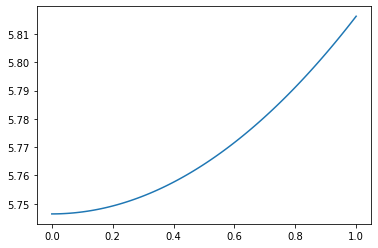

In [17]:
num_points = 100
P_0 = np.asarray(PD_actual_params)
P_1 = parametersadd
errors = []
xs = np.linspace(0, 1, num_points)

for x in xs:
    point = x*P_0+(1-x)*P_1
    errors.append(error_measure(point))
    
plt.plot(xs, errors)
plt.show()

This is a useful way of estimating the correct parameters and visualising how good the model and estimated parameters fit the data. However, it would also be useful to know how sure we are on these parameter values. To do this we use Bayesian inference and MCMC to sample the parameter space and give a distribution of probable parameter values.

In [24]:
log_prior = pints.UniformLogPrior(lower_bound+[0]*3, upper_bound+[1000]*3)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)
num_iterations = (pints_model_simulated().n_parameters()+3)*3000

startpoints = [np.concatenate((np.asarray(parametersadd), np.asarray([0.1]*3))),np.concatenate((np.asarray(parametersadd)*0.8, np.asarray([0.05]*3))), np.concatenate((np.asarray(parametersadd)*1.2, np.asarray([0.2]*3)))]
mcmc = pints.MCMCController(log_posterior, 3, startpoints, method=pints.HaarioBardenetACMC)
mcmc.set_max_iterations(num_iterations)
# mcmc.set_log_to_screen(False)
samples = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.3
1     6      0         0.5       0          0:00.6
2     9      0         0.667     0.333      0:00.8
3     12     0         0.5       0.25       0:01.1
20    63     0         0.333     0.238      0:05.8
40    123    0         0.22      0.171      0:11.1
60    183    0         0.164     0.164      0:16.5
80    243    0         0.148     0.148      0:21.9
100   303    0         0.139     0.129      0:27.2
120   363    0         0.124     0.107438   0:32.4
140   423    0         0.106383  0.0922     0:37.8
160   483    0         0.0994    0.0807     0:43.2
180   543    0         0.0884    0.0718     0:48.5
Initial phase completed.
200   603    0         0.0796    0.0647     0:53.9
220   663    0.0271    0.104     0.095      0:59.5
240   723    0.0747    0.141     0.124      1:05.1
260   783   

3100  9303   0.197     0.205     0.211     12:14.0
3120  9363   0.197     0.205     0.211     12:18.4
3140  9423   0.197071  0.205     0.211     12:22.7
3160  9483   0.198     0.205     0.212591  12:27.7
3180  9543   0.198     0.205     0.213     12:32.3
3200  9603   0.199     0.206     0.214308  12:37.4
3220  9663   0.2       0.207     0.214     12:42.5
3240  9723   0.2       0.206     0.21444   12:47.8
3260  9783   0.2       0.206     0.214     12:52.8
3280  9843   0.199939  0.205     0.214     12:56.8
3300  9903   0.2       0.204     0.215     13:00.9
3320  9963   0.201     0.204     0.214     13:05.7
3340  10023  0.201736  0.204     0.214     13:10.6
3360  10083  0.202     0.204     0.215     13:15.5
3380  10143  0.203     0.203     0.214     13:20.4
3400  10203  0.203     0.203     0.213     13:24.7
3420  10263  0.203157  0.202     0.214     13:28.6
3440  10323  0.202848  0.201     0.214     13:32.8
3460  10383  0.202     0.2       0.2141    13:37.3
3480  10443  0.202528  0.199   

6320  18963  0.209     0.216105  0.218     24:57.7
6340  19023  0.209     0.216212  0.219     25:02.0
6360  19083  0.209     0.217     0.219     25:06.5
6380  19143  0.209     0.217     0.219     25:11.3
6400  19203  0.209     0.217     0.219     25:16.4
6420  19263  0.209     0.217     0.219     25:21.5
6440  19323  0.21      0.217     0.218     25:26.6
6460  19383  0.21      0.217149  0.218542  25:31.6
6480  19443  0.21      0.217     0.219     25:36.6
6500  19503  0.21      0.217     0.218     25:41.2
6520  19563  0.21      0.217     0.218     25:45.9
6540  19623  0.21      0.216     0.218     25:50.7
6560  19683  0.210029  0.217     0.218107  25:55.9
6580  19743  0.21      0.217     0.217     26:00.2
6600  19803  0.211     0.217     0.217     26:04.1
6620  19863  0.21      0.217     0.217     26:08.2
6640  19923  0.21      0.216     0.217     26:12.6
6660  19983  0.211     0.216     0.216484  26:17.1
6680  20043  0.211     0.216     0.216285  26:21.9
6700  20103  0.211     0.215341

9540  28623  0.217168  0.218845  0.218845  37:43.7
9560  28683  0.217     0.219     0.219     37:48.3
9580  28743  0.217     0.219     0.219     37:53.8
9600  28803  0.217     0.219     0.219     37:58.8
9620  28863  0.217     0.218     0.219     38:04.1
9640  28923  0.217     0.218857  0.218857  38:09.3
9660  28983  0.218     0.219     0.219     38:14.0
9680  29043  0.218     0.219     0.219     38:19.1
9700  29103  0.218     0.219     0.219     38:24.6
9720  29163  0.218     0.219     0.219     38:29.9
9740  29223  0.218     0.218766  0.219074  38:34.8
9760  29283  0.218     0.219     0.219     38:39.7
9780  29343  0.218     0.219     0.219405  38:45.0
9800  29403  0.218243  0.219     0.219     38:50.2
9820  29463  0.219     0.219     0.219     38:54.6
9840  29523  0.219     0.219     0.219     38:59.3
9860  29583  0.219     0.219     0.22      39:04.9
9880  29643  0.219     0.22      0.22      39:10.0
9900  29703  0.218     0.219     0.22      39:15.2
9920  29763  0.218     0.219   

12760 38283  0.219     0.223     0.224     50:28.6
12780 38343  0.219     0.223     0.224     50:32.6
12800 38403  0.219     0.223     0.225     50:37.7
12820 38463  0.219     0.223     0.224     50:42.3
12840 38523  0.219     0.223     0.225     50:46.4
12860 38583  0.219     0.223233  0.224     50:51.3
12880 38643  0.22      0.224     0.224     50:56.4
12900 38703  0.22      0.224     0.224     51:01.4
12920 38763  0.22      0.224     0.224     51:06.4
12940 38823  0.22      0.224     0.224094  51:10.7
12960 38883  0.22      0.224     0.224     51:15.4
12980 38943  0.22      0.224     0.224     51:20.2
13000 39003  0.22      0.224     0.223752  51:25.1
13020 39063  0.22      0.224     0.224     51:29.4
13040 39123  0.22      0.224     0.224     51:34.5
13060 39183  0.219     0.224     0.224     51:39.7
13080 39243  0.219     0.224     0.224     51:45.1
13100 39303  0.219     0.224105  0.224     51:50.2
13120 39363  0.219     0.224     0.224     51:54.9
13140 39423  0.22      0.224   

15980 47943  0.221     0.224     0.222     63:10.3
16000 48003  0.221     0.223861  0.222     63:15.3
16020 48063  0.221     0.224     0.222     63:20.2
16040 48123  0.221     0.224     0.222     63:25.4
16060 48183  0.220721  0.224     0.222153  63:30.4
16080 48243  0.220633  0.224     0.222     63:35.2
16100 48303  0.221     0.223837  0.222657  63:40.3
16120 48363  0.22      0.224     0.223     63:44.7
16140 48423  0.22      0.223654  0.223     63:49.3
16160 48483  0.22      0.224     0.223006  63:53.4
16180 48543  0.221     0.223     0.223163  63:58.6
16200 48603  0.221     0.223443  0.223     64:03.7
16220 48663  0.221     0.224     0.223     64:09.0
16240 48723  0.221     0.224     0.223     64:14.1
16260 48783  0.221     0.223787  0.223295  64:19.3
16280 48843  0.221     0.224     0.223     64:24.1
16300 48903  0.221     0.224     0.223     64:29.2
16320 48963  0.221     0.224     0.222903  64:34.2
16340 49023  0.221     0.224     0.223     64:39.2
16360 49083  0.221     0.224   

19200 57603  0.223     0.224     0.223     75:53.6
19220 57663  0.223     0.224     0.223     75:57.7
19240 57723  0.223     0.224     0.223     76:02.6
19260 57783  0.223     0.224     0.223301  76:06.8
19280 57843  0.223     0.224     0.223     76:11.2
19300 57903  0.223     0.224     0.223     76:15.6
19320 57963  0.223     0.224     0.223     76:20.0
19340 58023  0.223     0.224     0.223     76:24.2
19360 58083  0.223     0.224162  0.223     76:28.8
19380 58143  0.223     0.224     0.223     76:33.2
19400 58203  0.223     0.224     0.223     76:37.6
19420 58263  0.223212  0.224     0.223212  76:42.1
19440 58323  0.223     0.224     0.223     76:46.7
19460 58383  0.223267  0.224     0.223     76:51.0
19480 58443  0.223     0.224     0.223     76:55.9
19500 58503  0.223     0.224     0.223     77:00.3
19520 58563  0.223298  0.224     0.223     77:04.4
19540 58623  0.223223  0.224     0.223     77:08.2
19560 58683  0.223     0.224     0.223     77:12.2
19580 58743  0.223     0.224   

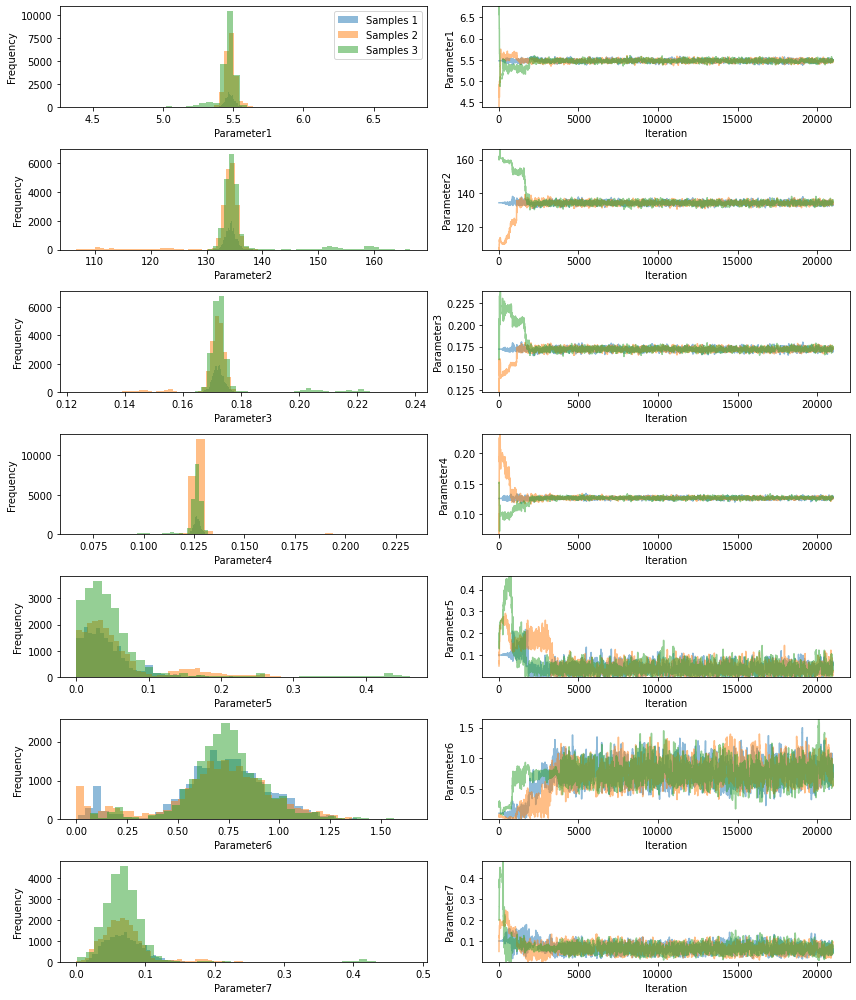

In [27]:
pints.plot.trace(samples)
plt.show()

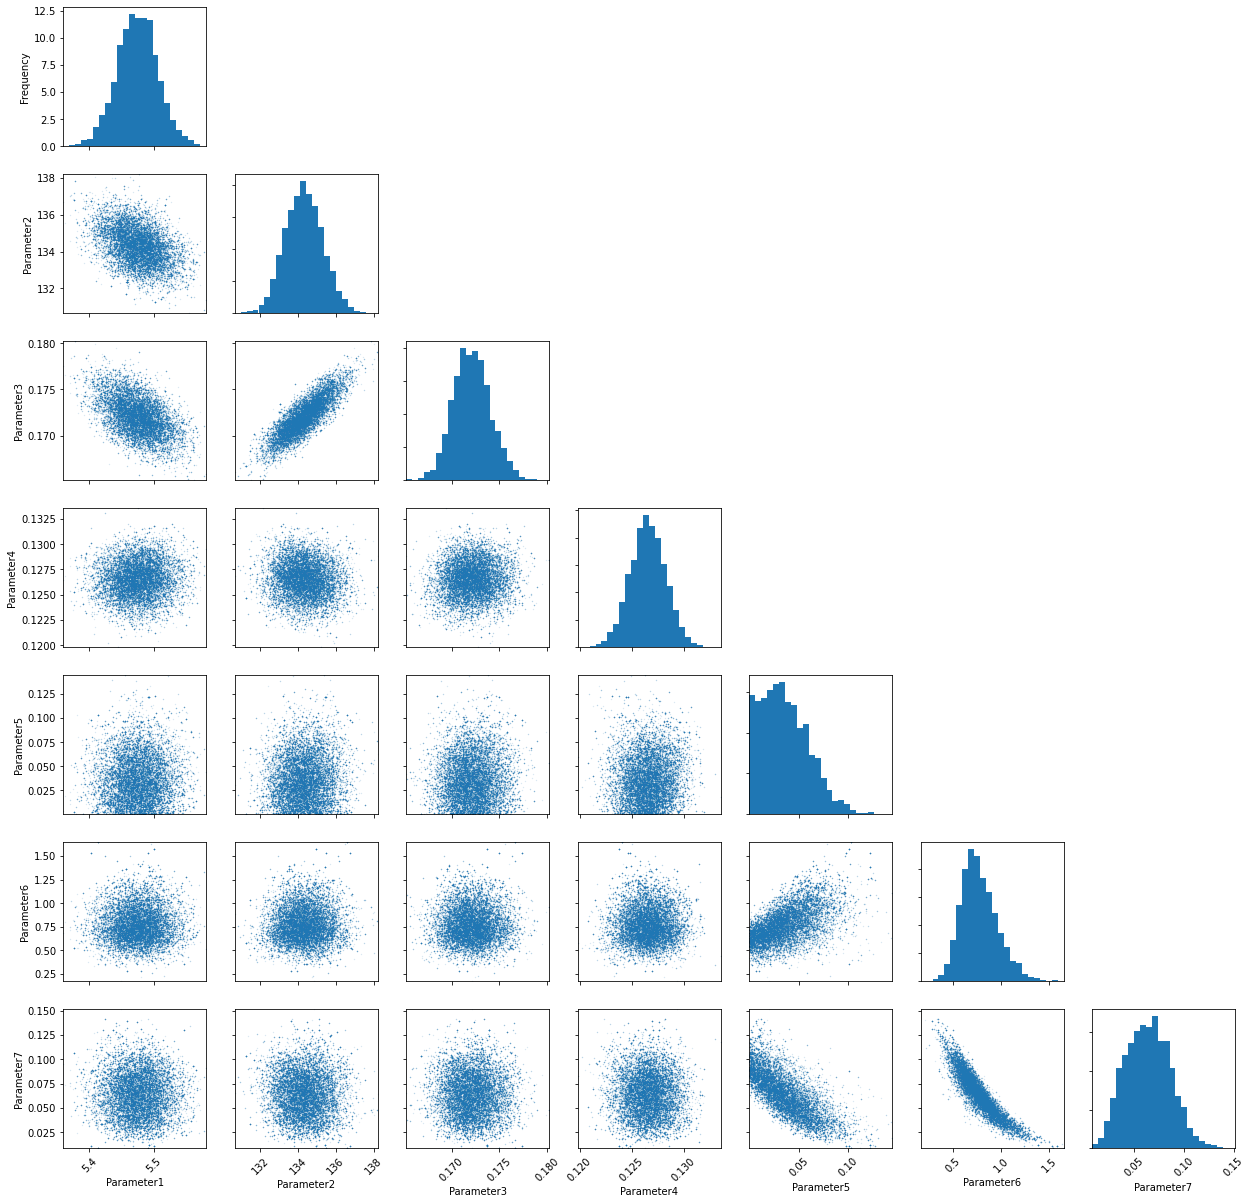

In [29]:
pints.plot.pairwise(np.vstack(samples[:,int(num_iterations/2):]))
plt.show()

### Real Data

Now we shall do the same as above but with Real data rather than simulated data. We do not know what the real parameters of the system are and so cannot truly know how accurately we are acquiring the correct results.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
from scipy import optimize, integrate
import pints
import pints.plot
import pandas
import plotly.express as px
import plotly.graph_objects as go
import nbformat

In [2]:
# Quick look at what the data contains
df = pandas.read_csv("0470-2008_2018-05-09.csv")
df = df.sort_values(['DOSE', 'TIME'], ascending=True)
group = df.groupby('DRUG')
df_view = group.apply(lambda x: x['DOSE'].unique())
df_view = df_view.apply(pandas.Series)
df_view = df_view.replace(np.nan, '', regex=True)
df_view.columns = ['Dose 1', "Dose 2", "Dose 3"]
print(df_view)

             Dose 1 Dose 2 Dose 3
DRUG                             
Controls        0.0              
Docetaxel       5.0   10.0   15.0
Irinotecan     34.0   68.0       
Topotecan       7.5   15.0       
Vinflunine     10.0   20.0       
Vinorelbine     5.0   10.0   20.0


In [3]:
# Options: change to one of the above drugs and corresponding dose
drug = 'Docetaxel'
observation = 'Platelets '
dose = 10
num_comp = 2

# Refine the Data
df = df.astype({'ID': 'int64'})
df_drug = df.loc[(df['DOSE'] == dose) & (df['DRUG'] == drug)] #
df_OBS = df_drug.loc[(df_drug['YNAME'] == observation)]
# Find average values
df_OBS = df_OBS.drop(df_OBS[df_OBS['OBS'] == '.'].index)[['TIME', 'DOSE', 'OBS']]
df_OBS = df_OBS.astype({'OBS': 'float64'})
df_stats = df_OBS[['TIME', 'DOSE', 'OBS']]
    # df_stats = df_stats.loc[(df_stats['DOSE'] == dose)]
df_stats = df_stats.astype({'OBS': 'float64'})
df_stats = df_stats.groupby(["TIME", "DOSE"], as_index=False).filter(lambda x: len(x) > 1).groupby(["TIME", "DOSE"], as_index=False).agg({'OBS':['mean','std']})
    # print(df_stats)
df_stats.columns = ['TIME', "DOSE", 'mean', 'std']
print(df_stats)

# Get actual dose amount
dose_amount = df_drug.drop(df_drug[df_drug['AMT'] == '.'].index).astype({'AMT': 'float64'}).mean()['AMT']
print("Average dose amount = " + str(dose_amount))

     TIME  DOSE         mean         std
0   -48.0  10.0   931.083333  122.426570
1    24.0  10.0   773.750000  100.154464
2    48.0  10.0   676.500000   69.173694
3    72.0  10.0   711.750000  135.234056
4    96.0  10.0   642.000000  119.635558
5   120.0  10.0   808.000000   96.249675
6   144.0  10.0   780.750000   90.973897
7   168.0  10.0   711.250000  135.418795
8   192.0  10.0   756.000000   51.961524
9   216.0  10.0   997.500000  170.486559
10  240.0  10.0  1122.500000  163.752863
11  264.0  10.0  1570.333333  214.537487
12  288.0  10.0  1092.500000  320.263954
13  312.0  10.0  1443.666667  177.472064
14  336.0  10.0  1407.000000  130.761870
15  360.0  10.0  1050.333333  210.138843
16  384.0  10.0  1090.750000   75.517658
17  432.0  10.0  1047.250000   91.405233
18  480.0  10.0   826.250000   61.602895
19  552.0  10.0   946.000000  182.383662
Average dose amount = 1.9767777777777777


In [4]:
from ipynb.fs.full.model_simulation import PintsPDFriberg # import the pints model
from ipynb.fs.full.model_simulation import ConstantAndMultiplicativeGaussianLogLikelihood
from ipynb.fs.full.model_simulation import ConstantAndMultiplicativeGaussianLogLikelihoodFixEta
from ipynb.fs.full.model_simulation import MultiplicativeGaussianLogLikelihoodFixEta
# import the liklihood

# Create the model in PINTS (This is the same model as above but with the new dose and num_comp)
PK_params=np.load('PK_parameters_real_'+drug+str(dose)+'.npy')
start_time = df_OBS['TIME'].min()
print(start_time)

pints_model_real = PintsPDFriberg(PK_params, dose, num_comp=num_comp, start_time=start_time)
    

-48.0


In [5]:
# Before starting the optimisation we should estimate the parameter Circ_0. We can do this by averaging over all 
# the values before time 0
df_before_0 = df_stats[df_stats["TIME"] < 0]
print(df_before_0)
times_before_dose = len(df_before_0["mean"])
Circ_0_approx = sum(df_before_0["mean"])/times_before_dose
print(Circ_0_approx)

   TIME  DOSE        mean        std
0 -48.0  10.0  931.083333  122.42657
931.0833333333334


In [6]:
# OSet up the problem
problem = pints.SingleOutputProblem(pints_model_real, np.asarray(df_stats['TIME'])-start_time, df_stats['mean'])
log_likelihood = ConstantAndMultiplicativeGaussianLogLikelihoodFixEta(problem)
parameter_names =['Circ_0', 'MTT', 'gamma', 'slope', 'sigma_base', 'sigma_rel']
error_measure = pints.ProbabilityBasedError(log_likelihood)
# error_measure = pints.SumOfSquaresError(problem)
lower_bound = [0.01*Circ_0_approx, 0.1, 0.01, 0.001, 0.0, 0.0]
upper_bound = [100*Circ_0_approx, 1000, 100, 10, 100, 10]

In [7]:
# Begin optimisation
optimisation = pints.OptimisationController(error_measure, [Circ_0_approx, 100, 1, 0.1, 0.1, 0.1], method=pints.CMAES, boundaries=pints.RectangularBoundaries(lower_bound, upper_bound))
# optimisation.set_log_to_screen(False)
parameters, error = optimisation.run()
np.save("./Data_and_parameters/pd_real_opt_combNoEta_params_dose_"+str(dose), parameters)

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 9


/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Iter. Eval. Best      Time m:s
0     9      265.1291   0:03.5


/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/model_simulation.ipynb:150: RuntimeWarning: invalid value encountered in power
  "        x_0 = np.array([dose, 0])\n",


1     18     208.8115   0:06.7
2     27     208.8115   0:09.3
3     36     208.8115   0:12.3

----------------------------------------
Unexpected termination.
Current best score: 208.8115457826791
Current best position:
 9.28724852428012355e+02
 9.85726069716221502e+01
 1.07087999008875334e+00
 2.53834778589032029e-01
 1.82681396208737001e+00
 1.41350247514821348e+00
----------------------------------------


KeyboardInterrupt: 

In [ ]:
# Quick visualisation
parameters = np.load("./Data_and_parameters/pd_real_opt_combNoEta_params_dose_"+str(dose)+".npy")

time_span = df_stats["TIME"].max()
times = np.linspace(start_time,time_span,1000)

# Show results
print('\t\tRun Likelihood')
print(parameter_names[0] + ': \t' + str(parameters[0]))
print(parameter_names[1] + ': \t\t' + str(parameters[1]))
print(parameter_names[2] + ': \t\t' + str(parameters[2]))
print(parameter_names[3] + ': \t\t' + str(parameters[3]))
print('Error: \t\t'+str(error_measure(parameters)))

In [8]:
# Visualisation using Plotly
y_label = drug + " Concentration"
x_label = "Time"

fig = px.scatter(
    df_stats,
    title=drug + " Concentration Mean",
    x="TIME",
    y="mean",
    error_y = "std",
    # facet_col="DOSE",
    # color="DOSE",
    width=800, 
    height=500,
)

fig.update_xaxes(title_text=x_label)
fig.update_yaxes(title_text=y_label)
fig.update_traces(mode='markers+lines')
fig['data'][0]['showlegend']=True
fig['data'][0]['name']='Observed Values'
fig.add_trace(go.Scatter(x=times, y=pints_model_real.simulate(parameters[:4], times-start_time),
                    mode='lines',
                    name='Prediction'))

fig.update_layout(
    updatemenus=[
        dict(
            type = "buttons",
            direction = "left",
            buttons=list([
                dict(
                    args=[{"yaxis.type": "linear"}],
                    label="Linear y-scale",
                    method="relayout"
                ),
                dict(
                    args=[{"yaxis.type": "log"}],
                    label="Log y-scale",
                    method="relayout"
                )
            ]),
            pad={"r": 0, "t": -10},
            showactive=True,
            x=1.0,
            xanchor="right",
            y=1.15,
            yanchor="top"
        ),
    ]
)
fig.show()

## MCMC Sampling

### Constant and Multiplicative Gaussian Logliklihood

In [12]:
# A look at the distribution of the parameters
parameters = np.load("./Data_and_parameters/pd_real_opt_combNoEta_params_dose_"+str(dose)+".npy")
log_likelihood = ConstantAndMultiplicativeGaussianLogLikelihoodFixEta(problem)
log_prior = pints.UniformLogPrior(np.asarray(lower_bound)*0.8, np.asarray(upper_bound)*1.2)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)
num_iterations = (pints_model_real.n_parameters()+3)*3000

startpoints = [np.asarray(parameters), np.asarray(parameters)*0.8, np.asarray(parameters)*1.2]
mcmc = pints.MCMCController(log_posterior, 3, startpoints, method=pints.HaarioBardenetACMC)
mcmc.set_max_iterations(num_iterations)
# mcmc.set_log_to_screen(False)
samples = mcmc.run()
np.save("./Data_and_parameters/pd_real_mcmc_combNoEta_params_dose_"+str(dose), samples)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.5
1     6      0         0         0          0:00.9
2     9      0         0.333     0          0:01.1
3     12     0.25      0.25      0          0:01.4
20    63     0.0952    0.286     0          0:04.9
40    123    0.0488    0.195122  0.0976     0:11.1
60    183    0.0328    0.23      0.164      0:17.0
80    243    0.0494    0.222     0.21       0:23.7
100   303    0.0693    0.208     0.267      0:30.7
120   363    0.0909    0.182     0.289      0:37.3
140   423    0.0922    0.156     0.291      0:43.9
160   483    0.087     0.149     0.286      0:51.2
180   543    0.0884    0.155     0.281768   0:59.1
Initial phase completed.
200   603    0.0896    0.174     0.264      1:06.6
220   663    0.136     0.213     0.299      1:14.6
240   723    0.158     0.232     0.303      1:22.0
260   783   

3100  9303   0.203     0.211     0.21      15:49.5
3120  9363   0.202     0.211     0.21      15:55.0
3140  9423   0.202     0.21      0.21      16:01.8
3160  9483   0.202     0.21      0.21      16:08.5
3180  9543   0.203     0.21      0.212     16:15.7
3200  9603   0.204     0.211     0.212     16:22.3
3220  9663   0.204     0.21      0.212     16:29.4
3240  9723   0.205     0.211046  0.213     16:35.7
3260  9783   0.205     0.211     0.213     16:42.0
3280  9843   0.206     0.211     0.21274   16:48.5
3300  9903   0.208     0.211     0.213     16:55.2
3320  9963   0.208371  0.211     0.212     17:02.4
3340  10023  0.208     0.212     0.212     17:08.3
3360  10083  0.208     0.212     0.212     17:14.4
3380  10143  0.207     0.212659  0.212     17:21.4
3400  10203  0.20788   0.214     0.213     17:27.9
3420  10263  0.207     0.215     0.213     17:34.4
3440  10323  0.206626  0.216     0.213     17:41.6
3460  10383  0.208     0.215     0.213     17:48.6
3480  10443  0.207     0.216   

6320  18963  0.212     0.212     0.221     32:10.8
6340  19023  0.213     0.214     0.221     32:16.6
6360  19083  0.212388  0.214     0.221     32:22.7
6380  19143  0.212     0.214     0.221     32:28.4
6400  19203  0.212     0.214     0.221     32:34.6
6420  19263  0.212     0.214     0.221     32:39.8
6440  19323  0.212     0.214     0.221     32:45.6
6460  19383  0.212     0.216     0.221     32:50.6
6480  19443  0.212     0.216     0.221     32:57.8
6500  19503  0.212275  0.217     0.221     33:03.5
6520  19563  0.212084  0.217     0.221     33:08.7
6540  19623  0.213     0.217     0.22122   33:14.5
6560  19683  0.21262   0.217     0.221     33:20.4
6580  19743  0.212     0.218052  0.221     33:25.9
6600  19803  0.213301  0.218     0.221     33:31.5
6620  19863  0.213     0.219     0.221     33:36.6
6640  19923  0.213     0.219     0.221051  33:43.0
6660  19983  0.213     0.219     0.221     33:49.1
6680  20043  0.214     0.219     0.221     33:55.5
6700  20103  0.214     0.219   

9540  28623  0.218     0.217     0.22      47:04.4
9560  28683  0.218178  0.217     0.22      47:10.4
9580  28743  0.218     0.216     0.22      47:15.4
9600  28803  0.218     0.217     0.22      47:20.4
9620  28863  0.218     0.217     0.22      47:25.4
9640  28923  0.218     0.216     0.22      47:32.0
9660  28983  0.218     0.216     0.22      47:38.6
9680  29043  0.218     0.216     0.22      47:44.5
9700  29103  0.218     0.216     0.22      47:49.8
9720  29163  0.218     0.216     0.220142  47:55.8
9740  29223  0.218     0.216     0.221     48:02.4
9760  29283  0.217908  0.216     0.221     48:08.0
9780  29343  0.218     0.217     0.221     48:14.3
9800  29403  0.219     0.217     0.221     48:20.2
9820  29463  0.219     0.217     0.221     48:26.2
9840  29523  0.22      0.217     0.221     48:32.3
9860  29583  0.219     0.217625  0.221     48:37.9
9880  29643  0.219     0.218     0.221     48:43.9
9900  29703  0.219     0.218     0.221     48:50.4
9920  29763  0.219     0.218   

12760 38283  0.222     0.222     0.223     62:33.4
12780 38343  0.222     0.222     0.222596  62:39.0
12800 38403  0.222     0.222     0.223     62:45.4
12820 38463  0.221     0.222     0.223     62:51.2
12840 38523  0.221     0.222     0.223     62:57.6
12860 38583  0.222     0.222     0.223     63:04.1
12880 38643  0.222     0.222     0.223     63:09.7
12900 38703  0.222     0.222     0.222     63:16.0
12920 38763  0.222     0.222     0.223     63:21.4
12940 38823  0.222     0.222     0.222     63:26.9
12960 38883  0.222     0.222     0.223     63:32.6
12980 38943  0.222     0.222     0.223     63:39.0
13000 39003  0.222     0.222     0.222     63:44.4
13020 39063  0.222     0.222     0.223     63:50.7
13040 39123  0.222     0.222     0.223     63:57.4
13060 39183  0.222     0.222     0.223     64:02.8
13080 39243  0.222     0.222     0.223     64:09.2
13100 39303  0.222     0.222     0.222     64:14.6
13120 39363  0.222     0.222     0.222     64:20.3
13140 39423  0.221977  0.223   

15980 47943  0.222     0.224     0.225     77:43.2
16000 48003  0.222     0.224     0.225     77:48.7
16020 48063  0.222     0.224     0.225     77:54.0
16040 48123  0.222     0.224     0.225     78:00.3
16060 48183  0.222     0.224     0.225     78:06.1
16080 48243  0.222     0.224     0.225     78:09.8
16100 48303  0.221539  0.224     0.225     78:14.7
16120 48363  0.221     0.224     0.224     78:20.8
16140 48423  0.221     0.224     0.224     78:26.3
16160 48483  0.221     0.224     0.224     78:32.1
16180 48543  0.221     0.224     0.224     78:37.6
16200 48603  0.221     0.224     0.224     78:43.5
16220 48663  0.221     0.224     0.224     78:48.9
16240 48723  0.221     0.224     0.223     78:54.2
16260 48783  0.221     0.225     0.223     78:59.7
16280 48843  0.221     0.225     0.223205  79:05.8
16300 48903  0.221     0.225     0.223     79:11.8
16320 48963  0.221     0.225     0.223     79:17.5
16340 49023  0.221     0.225     0.223     79:23.1
16360 49083  0.221     0.225   

19200 57603  0.225     0.225     0.226     93:26.4
19220 57663  0.225     0.225     0.226     93:31.9
19240 57723  0.225     0.225     0.226     93:38.3
19260 57783  0.225     0.225     0.226     93:44.6
19280 57843  0.225     0.225507  0.226     93:49.5
19300 57903  0.225     0.225     0.226465  93:54.3
19320 57963  0.226     0.225     0.227     93:58.3
19340 58023  0.225     0.225     0.226     94:03.0
19360 58083  0.226     0.225     0.226     94:08.1
19380 58143  0.226     0.225     0.227     94:14.2
19400 58203  0.226     0.225     0.227     94:20.4
19420 58263  0.225     0.225     0.226     94:26.0
19440 58323  0.226     0.225     0.226     94:31.4
19460 58383  0.226     0.225     0.226     94:37.0
19480 58443  0.226     0.225     0.226     94:42.1
19500 58503  0.226     0.225     0.226     94:47.0
19520 58563  0.226     0.225     0.226     94:53.0
19540 58623  0.226     0.225     0.226     94:58.3
19560 58683  0.226     0.225     0.226     95:03.8
19580 58743  0.225678  0.225   

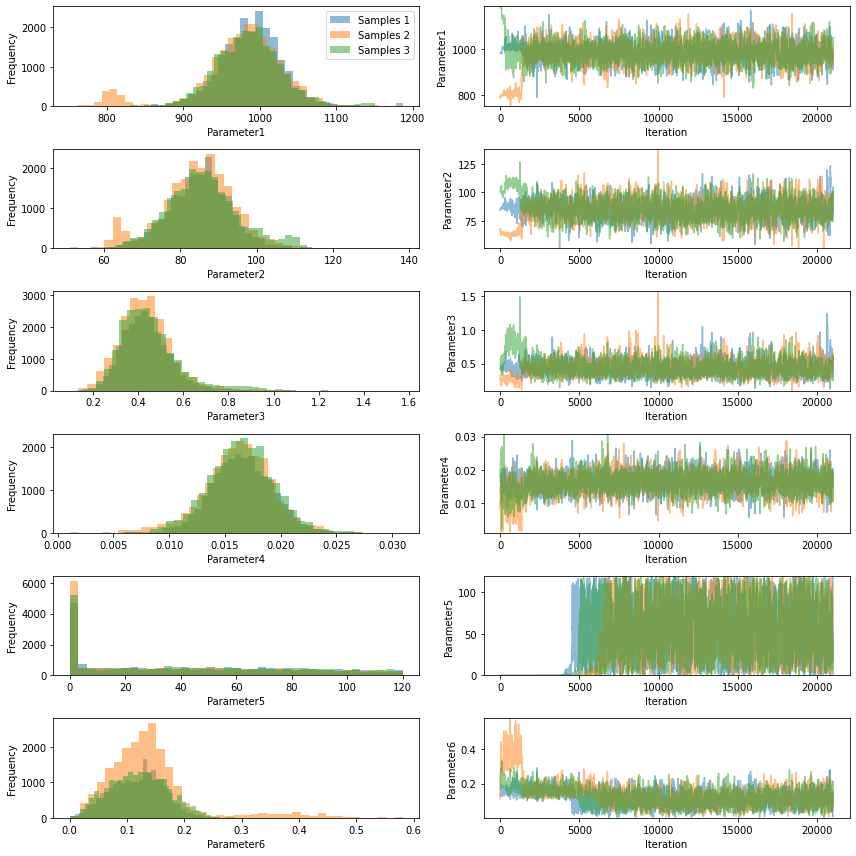

In [9]:
samples = np.load("./Data_and_parameters/pd_real_mcmc_combNoEta_params_dose_"+str(dose)+".npy")
pints.plot.trace(samples)
plt.show()

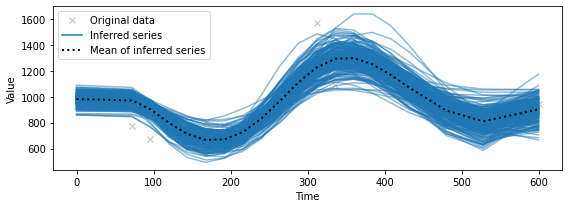

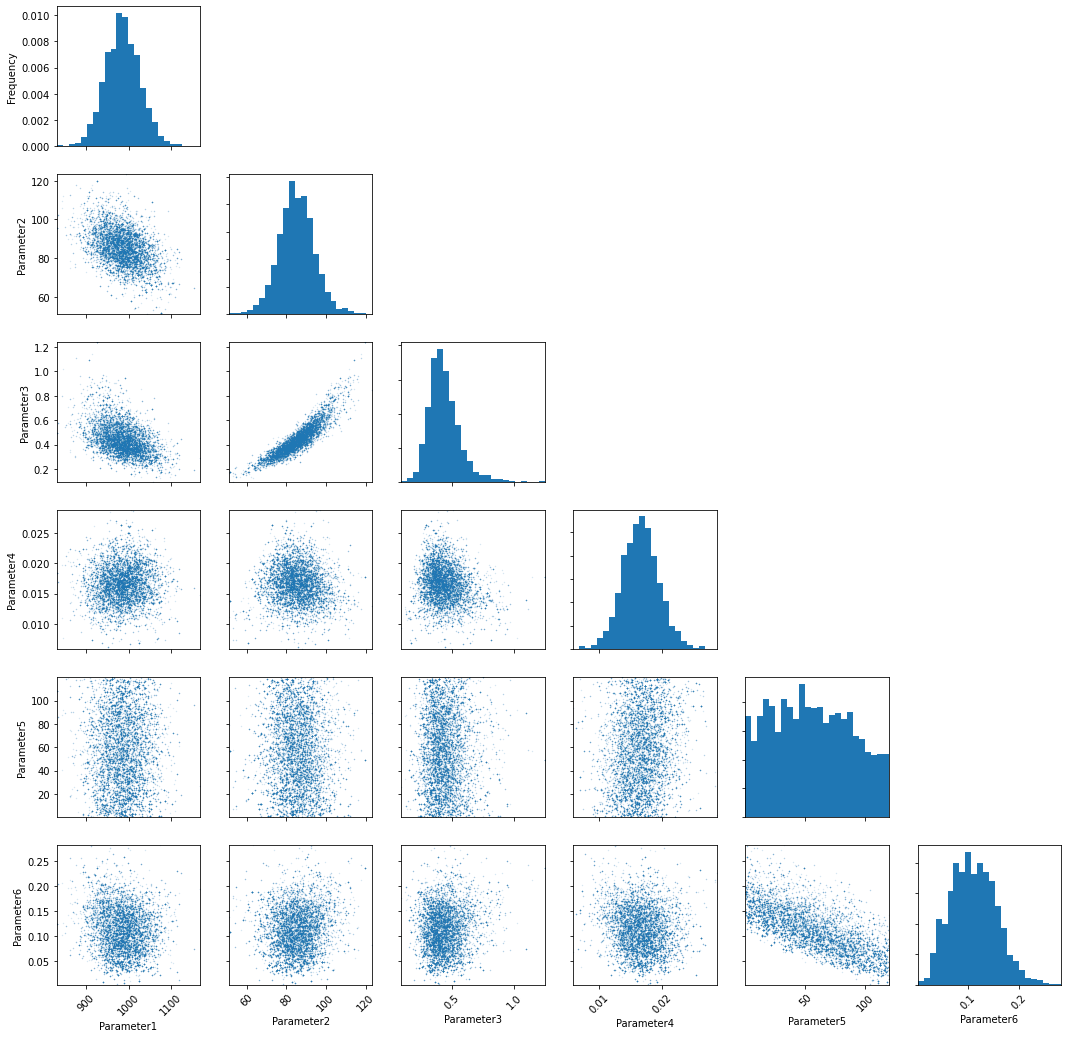

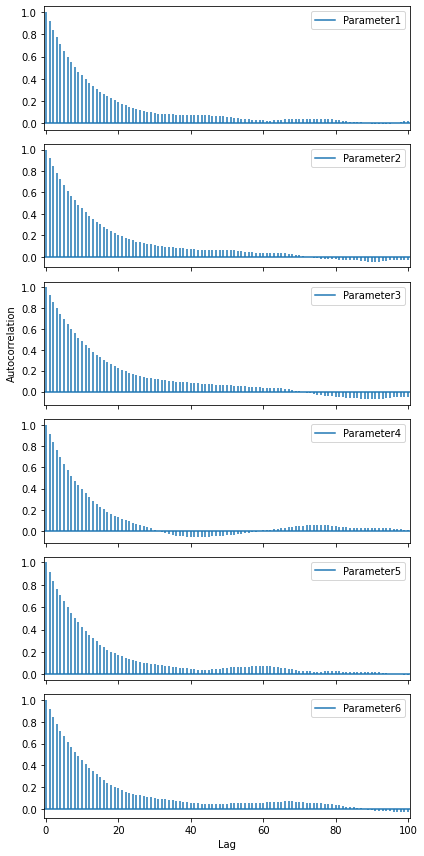

In [14]:
pints.plot.series(np.vstack(samples[:,int(3*num_iterations/4):]), problem)
plt.show()
pints.plot.pairwise(np.vstack(samples[:,int(3*num_iterations/4):]))
plt.show()
pints.plot.autocorrelation(np.vstack(samples[:,int(3*num_iterations/4):]))
plt.show()

In [15]:
pints.rhat(samples)

array([1.02516179, 1.01409277, 1.01171219, 1.00799167, 1.10692784,
       1.09111119])

### Constant Gaussian Loglikelihood

In [10]:
# A look at the distribution of the parameters
parameters = np.load("./Data_and_parameters/pd_real_opt_combNoEta_params_dose_"+str(dose)+".npy")
log_likelihood = pints.GaussianLogLikelihood(problem)
log_prior = pints.UniformLogPrior(np.asarray(lower_bound[:5])*0.8, np.asarray(upper_bound[:5])*1.2)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)
num_iterations = (pints_model_real.n_parameters()+3)*3000

startpoints = [np.asarray(parameters[:5]), np.asarray(parameters[:5])*0.8, np.asarray(parameters[:5])*1.2]
mcmc = pints.MCMCController(log_posterior, 3, startpoints, method=pints.HaarioBardenetACMC)
mcmc.set_max_iterations(num_iterations)
# mcmc.set_log_to_screen(False)
samples = mcmc.run()
np.save("./Data_and_parameters/pd_real_mcmc_add_params_dose_"+str(dose), samples)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.3
1     6      0         0         0.5        0:00.4
2     9      0         0         0.333      0:00.4
3     12     0         0.25      0.25       0:00.5
20    63     0.333     0.333     0.143      0:05.6
40    123    0.268     0.293     0.268      0:11.9
60    183    0.23      0.279     0.213      0:16.6
80    243    0.222     0.247     0.21       0:24.0
100   303    0.198     0.257     0.238      0:30.1
120   363    0.165     0.24      0.223      0:37.9
140   423    0.141844  0.22      0.248227   0:46.2
160   483    0.136646  0.242236  0.224      0:53.4
180   543    0.133     0.238     0.198895   1:00.3
Initial phase completed.
200   603    0.124     0.234     0.189      1:07.7
220   663    0.163     0.258     0.199095   1:15.7
240   723    0.174     0.27      0.199      1:23.0
260   783   

3100  9303   0.0429    0.115     0.162     13:33.6
3120  9363   0.0426    0.115     0.161     13:38.0
3140  9423   0.0423    0.114     0.16      13:42.6
3160  9483   0.0421    0.113888  0.159     13:47.4
3180  9543   0.0418    0.113     0.158     13:52.6
3200  9603   0.0415    0.113     0.158     13:58.6
3220  9663   0.0413    0.112077  0.157     14:04.1
3240  9723   0.041     0.111     0.156     14:10.2
3260  9783   0.0408    0.111     0.155     14:16.1
3280  9843   0.0405    0.11      0.154     14:22.2
3300  9903   0.0403    0.109     0.154     14:28.0
3320  9963   0.04      0.109     0.152966  14:33.5
3340  10023  0.0401    0.108     0.152     14:39.5
3360  10083  0.0399    0.107     0.151     14:45.6
3380  10143  0.0396    0.107     0.15      14:51.8
3400  10203  0.0394    0.106     0.149     14:57.5
3420  10263  0.0398    0.105817  0.148     15:03.4
3440  10323  0.0401    0.106     0.148     15:09.3
3460  10383  0.0399    0.106     0.147     15:15.4
3480  10443  0.0396    0.105   

6320  18963  0.281     0.128     0.109     29:08.6
6340  19023  0.283     0.128     0.11      29:14.5
6360  19083  0.285     0.128     0.112     29:20.3
6380  19143  0.287     0.127     0.114     29:26.4
6400  19203  0.289     0.127     0.115     29:32.9
6420  19263  0.291     0.126     0.116     29:39.5
6440  19323  0.292     0.126     0.116     29:45.4
6460  19383  0.293     0.126     0.117     29:51.1
6480  19443  0.293     0.125     0.119     29:57.0
6500  19503  0.295     0.125     0.119     30:02.3
6520  19563  0.296     0.125     0.121     30:08.0
6540  19623  0.297     0.12414   0.121     30:13.2
6560  19683  0.297668  0.124     0.123     30:18.6
6580  19743  0.299     0.123     0.124905  30:24.1
6600  19803  0.301318  0.123     0.125     30:29.5
6620  19863  0.302     0.123     0.126     30:34.8
6640  19923  0.303     0.123     0.127541  30:40.0
6660  19983  0.304     0.122     0.129     30:45.3
6680  20043  0.305     0.121838  0.13      30:50.6
6700  20103  0.305     0.121   

9540  28623  0.234     0.0878    0.223     45:20.6
9560  28683  0.233     0.0876    0.224     45:27.6
9580  28743  0.233     0.0875    0.223985  45:34.2
9600  28803  0.232     0.0875    0.224     45:41.0
9620  28863  0.232     0.0873    0.224     45:47.7
9640  28923  0.231615  0.0874    0.225     45:53.3
9660  28983  0.231     0.0873    0.226     45:58.4
9680  29043  0.230658  0.0872    0.226     46:04.0
9700  29103  0.23      0.087     0.227     46:09.7
9720  29163  0.23      0.087     0.227     46:15.3
9740  29223  0.229     0.0871    0.228     46:21.2
9760  29283  0.229     0.087     0.229     46:27.5
9780  29343  0.228     0.0868    0.229     46:33.9
9800  29403  0.228     0.0867    0.23      46:40.0
9820  29463  0.227     0.0865    0.23      46:45.5
9840  29523  0.227     0.0865    0.230566  46:50.8
9860  29583  0.226     0.0865    0.231     46:57.3
9880  29643  0.226     0.0863    0.232     47:04.4
9900  29703  0.226     0.0862    0.233     47:10.2
9920  29763  0.225     0.086   

12760 38283  0.175     0.134     0.223     56:12.5
12780 38343  0.175     0.135     0.222     56:15.4
12800 38403  0.175     0.136     0.222092  56:18.4
12820 38463  0.175     0.137     0.222     56:21.3
12840 38523  0.174     0.138307  0.221     56:23.8
12860 38583  0.174     0.139     0.221     56:26.3
12880 38643  0.174     0.14      0.221     56:28.9
12900 38703  0.174     0.142     0.22      56:31.4
12920 38763  0.173     0.142     0.22      56:34.2
12940 38823  0.173016  0.143     0.22      56:37.0
12960 38883  0.172749  0.144     0.219     56:39.8
12980 38943  0.172     0.144     0.219     56:42.4
13000 39003  0.172     0.145     0.219     56:46.0
13020 39063  0.171953  0.146     0.218     56:49.0
13040 39123  0.172     0.147     0.218     56:51.8
13060 39183  0.171     0.148     0.218     56:54.7
13080 39243  0.171     0.149377  0.217     56:57.5
13100 39303  0.170903  0.15      0.217     57:00.9
13120 39363  0.171     0.152     0.217     57:03.9
13140 39423  0.17      0.153   

15980 47943  0.143     0.28      0.179     64:13.8
16000 48003  0.143     0.281     0.178     64:17.2
16020 48063  0.143     0.282     0.178     64:19.8
16040 48123  0.143     0.282     0.178     64:23.1
16060 48183  0.142     0.283     0.178     64:26.0
16080 48243  0.142     0.283     0.177     64:29.5
16100 48303  0.142     0.284     0.177194  64:33.4
16120 48363  0.142     0.285     0.177     64:37.9
16140 48423  0.142     0.285     0.177     64:41.5
16160 48483  0.142256  0.286     0.177     64:44.8
16180 48543  0.142     0.287     0.176     64:48.1
16200 48603  0.142     0.287     0.176162  64:51.6
16220 48663  0.142223  0.288     0.176     64:54.6
16240 48723  0.142     0.288     0.176     64:58.1
16260 48783  0.143     0.289     0.175512  65:01.8
16280 48843  0.142     0.29      0.175     65:05.3
16300 48903  0.143     0.29      0.175     65:08.7
16320 48963  0.143     0.291     0.175     65:12.3
16340 49023  0.143     0.291353  0.175     65:16.1
16360 49083  0.143     0.292   

19200 57603  0.204     0.274     0.149     73:03.7
19220 57663  0.204     0.273711  0.149     73:07.9
19240 57723  0.205     0.273     0.149     73:11.4
19260 57783  0.205     0.273     0.149     73:14.8
19280 57843  0.205     0.273     0.148     73:17.2
19300 57903  0.206     0.273     0.148     73:20.3
19320 57963  0.207     0.272     0.148     73:23.4
19340 58023  0.207     0.272     0.148     73:26.6
19360 58083  0.208     0.272     0.148     73:29.5
19380 58143  0.209     0.271     0.147722  73:32.3
19400 58203  0.21      0.271     0.148     73:35.6
19420 58263  0.21      0.271     0.147     73:38.4
19440 58323  0.211     0.271     0.147     73:41.5
19460 58383  0.212     0.27      0.147     73:45.0
19480 58443  0.212     0.270058  0.147     73:48.3
19500 58503  0.213     0.269781  0.146813  73:50.8
19520 58563  0.214     0.27      0.147     73:53.4
19540 58623  0.214     0.269     0.147     73:55.6
19560 58683  0.215     0.269     0.146     73:59.0
19580 58743  0.215515  0.269   

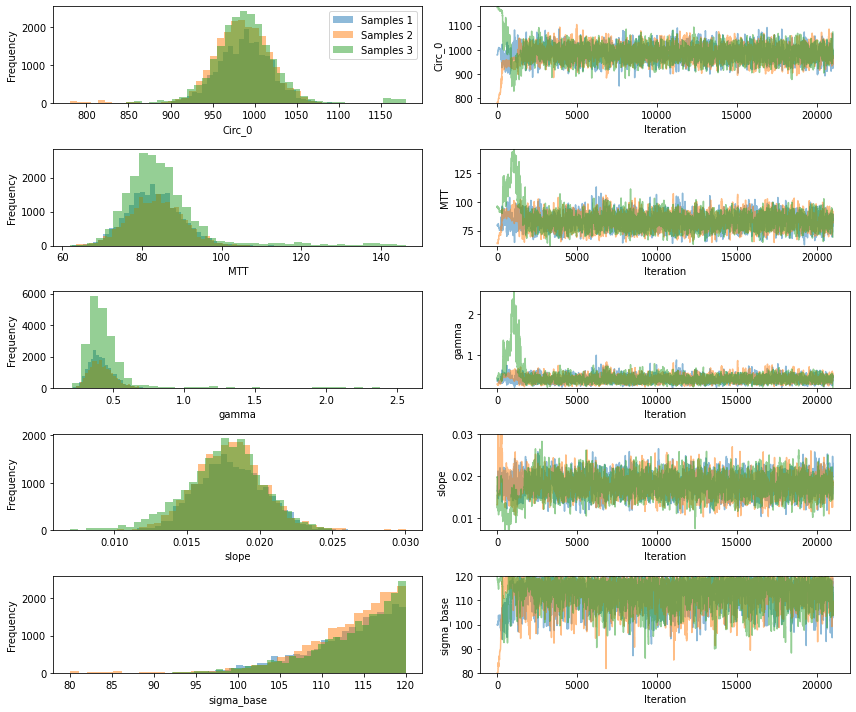

In [35]:
samples = np.load("./Data_and_parameters/pd_real_mcmc_combNoEta_params_dose_"+str(dose)+".npy")
pints.plot.trace(samples, parameter_names=parameter_names[:5])
plt.show()

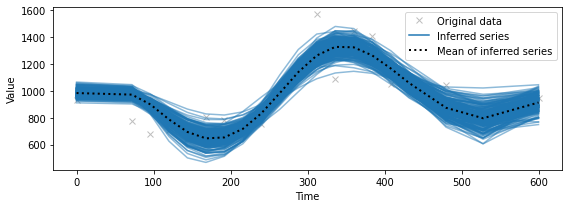

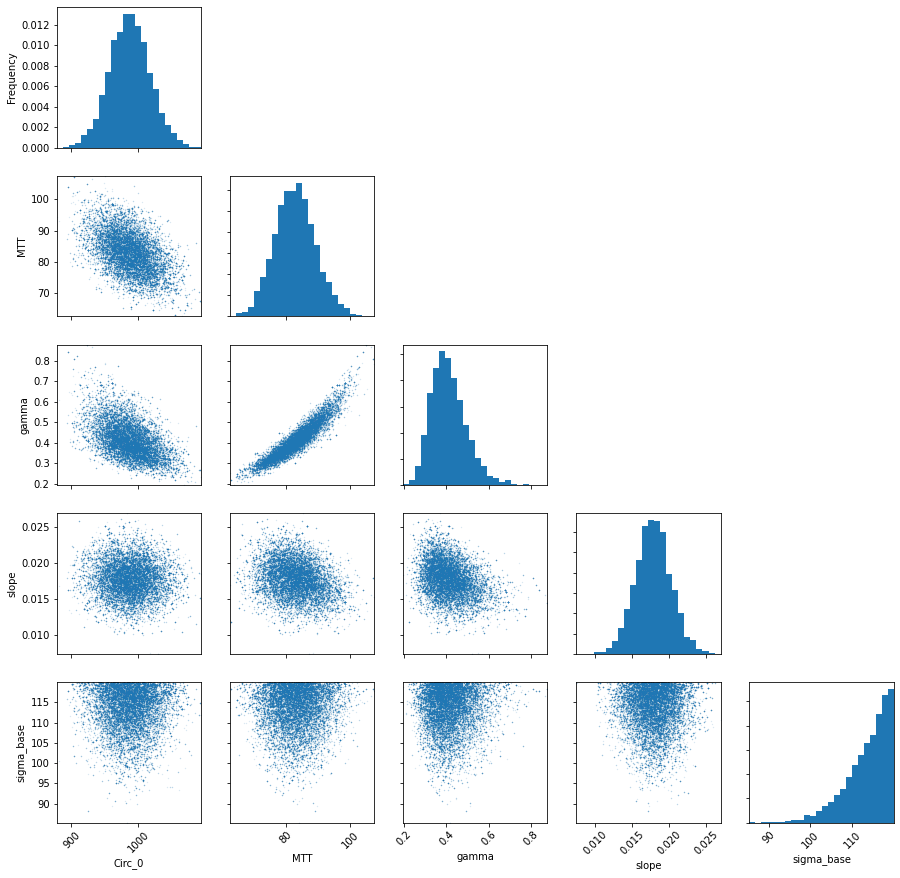

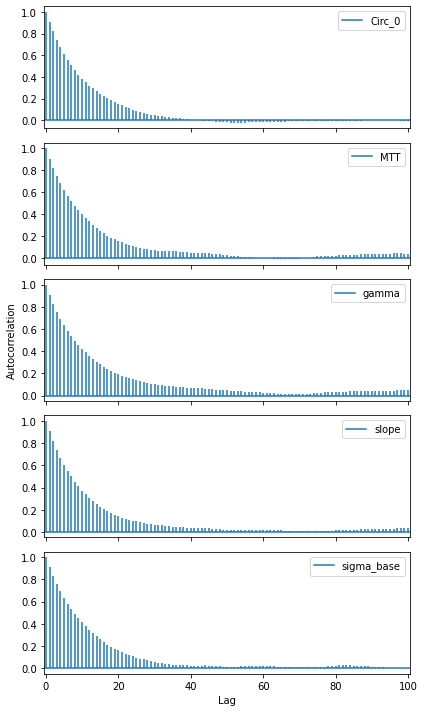

array([1.0056111 , 1.0258302 , 1.03543578, 1.01018448, 1.00444582])

In [36]:
pints.plot.series(np.vstack(samples[:,int(2*num_iterations/4):]), problem)
plt.show()
pints.plot.pairwise(np.vstack(samples[:,int(2*num_iterations/4):]), parameter_names=parameter_names[:5])
plt.show()
pints.plot.autocorrelation(np.vstack(samples[:,int(2*num_iterations/4):]), parameter_names=parameter_names[:5])
plt.show()
pints.rhat(samples)

In [9]:
# A look at the distribution of the parameters
parameters = np.load("./Data_and_parameters/pd_real_opt_combNoEta_params_dose_"+str(dose)+".npy")

lower_bound = [0.01*Circ_0_approx, 0.1, 0.01, 0.001, 0.0]
upper_bound = [100*Circ_0_approx, 1000, 100, 10, 10]

log_likelihood = MultiplicativeGaussianLogLikelihoodFixEta(problem)
log_prior = pints.UniformLogPrior(np.asarray(lower_bound)*0.8, np.asarray(upper_bound)*1.2)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)
num_iterations = (pints_model_real.n_parameters()+3)*3000

print(parameters)

[9.87182190e+02 8.42956640e+01 4.14055226e-01 1.65377881e-02
 1.48100237e-12 1.38470015e-01]


In [7]:
start_point = np.concatenate((np.asarray(parameters[:4]),np.asarray(parameters[5:])))

startpoints = [start_point, start_point*0.8, start_point*1.2]
mcmc = pints.MCMCController(log_posterior, 3, startpoints, method=pints.HaarioBardenetACMC)
mcmc.set_max_iterations(num_iterations)
# mcmc.set_log_to_screen(False)
samples = mcmc.run()
np.save("./Data_and_parameters/pd_real_mcmc_multNoEta_params_dose_"+str(dose), samples)

[9.87182190e+02 8.42956640e+01 4.14055226e-01 1.65377881e-02
 1.48100237e-12 1.38470015e-01]
Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.3
1     6      0         0         0.5        0:00.5
2     9      0         0         0.333      0:00.7
3     12     0         0         0.25       0:00.9
20    63     0         0.19      0.143      0:05.6
40    123    0.0244    0.22      0.195122   0:10.2
60    183    0.0492    0.18      0.23       0:15.4
80    243    0.0741    0.173     0.235      0:20.5
100   303    0.099     0.218     0.257      0:25.4
120   363    0.116     0.214876  0.256      0:30.2
140   423    0.113     0.206     0.277      0:35.0
160   483    0.0994    0.211     0.286      0:39.8
180   543    0.0939    0.21      0.281768   0:45.0
Initial phase completed.
200   603    0.109     0.224     0.289      0:49.8
220   663    0.149   

3060  9183   0.204     0.212     0.22      14:35.3
3080  9243   0.204     0.212     0.22      14:41.3
3100  9303   0.204     0.212     0.22      14:47.4
3120  9363   0.203     0.212     0.22      14:53.5
3140  9423   0.202     0.214     0.220312  14:59.5
3160  9483   0.202     0.214     0.22      15:05.5
3180  9543   0.202     0.214     0.219     15:11.3
3200  9603   0.203     0.214     0.218     15:17.0
3220  9663   0.205     0.215     0.218     15:22.6
3240  9723   0.204     0.214     0.217834  15:28.3
3260  9783   0.205     0.213     0.217418  15:34.1
3280  9843   0.205     0.214     0.218     15:40.1
3300  9903   0.205     0.215     0.218     15:45.8
3320  9963   0.205     0.216     0.217     15:51.5
3340  10023  0.205     0.217     0.216     15:57.2
3360  10083  0.205     0.217     0.217     16:03.0
3380  10143  0.204     0.215     0.217     16:08.7
3400  10203  0.203     0.215     0.218     16:14.6
3420  10263  0.203     0.215     0.219     16:20.2
3440  10323  0.204     0.216   

6280  18843  0.216     0.216     0.222     30:28.0
6300  18903  0.216     0.216     0.222     30:33.7
6320  18963  0.216     0.216     0.221     30:39.5
6340  19023  0.216     0.216     0.222     30:45.1
6360  19083  0.216     0.216     0.222     30:51.0
6380  19143  0.216     0.216     0.221     30:56.5
6400  19203  0.216     0.21606   0.221     31:02.1
6420  19263  0.216     0.21601   0.221     31:08.1
6440  19323  0.216     0.216     0.22      31:14.0
6460  19383  0.217     0.216     0.221     31:19.7
6480  19443  0.217     0.217     0.221     31:25.7
6500  19503  0.217     0.217     0.22      31:31.4
6520  19563  0.217     0.217298  0.22      31:37.3
6540  19623  0.217     0.217398  0.22      31:43.2
6560  19683  0.217     0.217     0.221     31:49.1
6580  19743  0.218     0.218     0.221091  31:54.9
6600  19803  0.218     0.218     0.221     32:00.7
6620  19863  0.217     0.217     0.221     32:06.4
6640  19923  0.217     0.217     0.221     32:12.0
6660  19983  0.216     0.218   

9500  28503  0.218     0.222     0.226292  46:41.1
9520  28563  0.219     0.222     0.226     46:47.0
9540  28623  0.219     0.222     0.226601  46:52.9
9560  28683  0.219     0.222     0.227     46:58.9
9580  28743  0.22      0.222     0.227     47:05.1
9600  28803  0.22      0.222     0.227     47:11.1
9620  28863  0.22      0.222     0.227     47:17.1
9640  28923  0.22      0.222     0.227     47:23.2
9660  28983  0.22006   0.222     0.227     47:29.2
9680  29043  0.219812  0.222     0.227     47:35.3
9700  29103  0.22      0.221     0.226     47:42.2
9720  29163  0.22      0.221     0.226     47:48.9
9740  29223  0.22      0.221     0.226     47:55.6
9760  29283  0.22      0.221     0.226     48:02.5
9780  29343  0.22      0.221143  0.226     48:09.1
9800  29403  0.22      0.221     0.226     48:15.8
9820  29463  0.22      0.221     0.227     48:21.7
9840  29523  0.22      0.221     0.227     48:27.5
9860  29583  0.22      0.221     0.227     48:33.4
9880  29643  0.22      0.221   

12720 38163  0.221     0.222624  0.228     62:53.0
12740 38223  0.222     0.223     0.228     62:59.0
12760 38283  0.221     0.223     0.228     63:05.2
12780 38343  0.221     0.223     0.228     63:11.3
12800 38403  0.221389  0.223     0.228     63:17.2
12820 38463  0.221     0.223     0.228     63:23.2
12840 38523  0.222     0.223425  0.228     63:29.4
12860 38583  0.222     0.224     0.228     63:35.4
12880 38643  0.222     0.224     0.228     63:41.3
12900 38703  0.222     0.224     0.228     63:47.5
12920 38763  0.222     0.225     0.228     63:53.6
12940 38823  0.222     0.225     0.228     63:59.7
12960 38883  0.222     0.225     0.228     64:05.9
12980 38943  0.222     0.225     0.228     64:12.1
13000 39003  0.222     0.224675  0.228     64:18.1
13020 39063  0.222     0.225     0.228     64:24.2
13040 39123  0.223     0.225     0.229     64:30.4
13060 39183  0.222571  0.225     0.229     64:36.5
13080 39243  0.223     0.225     0.229     64:42.4
13100 39303  0.223     0.22525 

15940 47823  0.225     0.226021  0.223     79:16.7
15960 47883  0.225     0.226051  0.223     79:22.4
15980 47943  0.225     0.226     0.22314   79:28.4
16000 48003  0.225     0.226     0.223     79:34.1
16020 48063  0.225     0.22664   0.223     79:39.8
16040 48123  0.225173  0.227     0.223     79:44.9
16060 48183  0.225     0.226636  0.223336  79:50.5
16080 48243  0.225     0.227     0.223307  79:56.5
16100 48303  0.225     0.226694  0.223     80:02.3
16120 48363  0.225     0.227     0.224     80:08.2
16140 48423  0.225     0.227     0.223654  80:14.1
16160 48483  0.225     0.226     0.224     80:20.1
16180 48543  0.225     0.226     0.224     80:26.1
16200 48603  0.224     0.226     0.224     80:32.1
16220 48663  0.224     0.22588   0.224     80:38.1
16240 48723  0.224     0.226     0.224     80:44.1
16260 48783  0.225     0.226     0.223664  80:50.1
16280 48843  0.225     0.226     0.224     80:55.9
16300 48903  0.225     0.226     0.223974  81:01.7
16320 48963  0.225     0.226   

19160 57483  0.227     0.229059  0.228     95:31.7
19180 57543  0.226422  0.229     0.228     95:38.2
19200 57603  0.226     0.229     0.228     95:44.7
19220 57663  0.226     0.229     0.228344  95:51.2
19240 57723  0.226     0.229     0.228     95:57.8
19260 57783  0.226     0.229     0.228     96:04.3
19280 57843  0.226     0.229345  0.228     96:10.9
19300 57903  0.226     0.22947   0.228     96:17.5
19320 57963  0.226     0.229     0.228     96:24.0
19340 58023  0.226     0.229     0.228     96:30.3
19360 58083  0.226     0.229     0.228     96:36.4
19380 58143  0.226     0.23      0.228     96:42.8
19400 58203  0.226     0.23      0.228     96:49.2
19420 58263  0.226147  0.23      0.228     96:55.7
19440 58323  0.226     0.229875  0.228     97:01.7
19460 58383  0.226     0.23      0.228     97:07.7
19480 58443  0.226     0.23      0.228     97:13.4
19500 58503  0.226091  0.23      0.228296  97:19.2
19520 58563  0.226     0.23      0.228267  97:24.8
19540 58623  0.226     0.23    

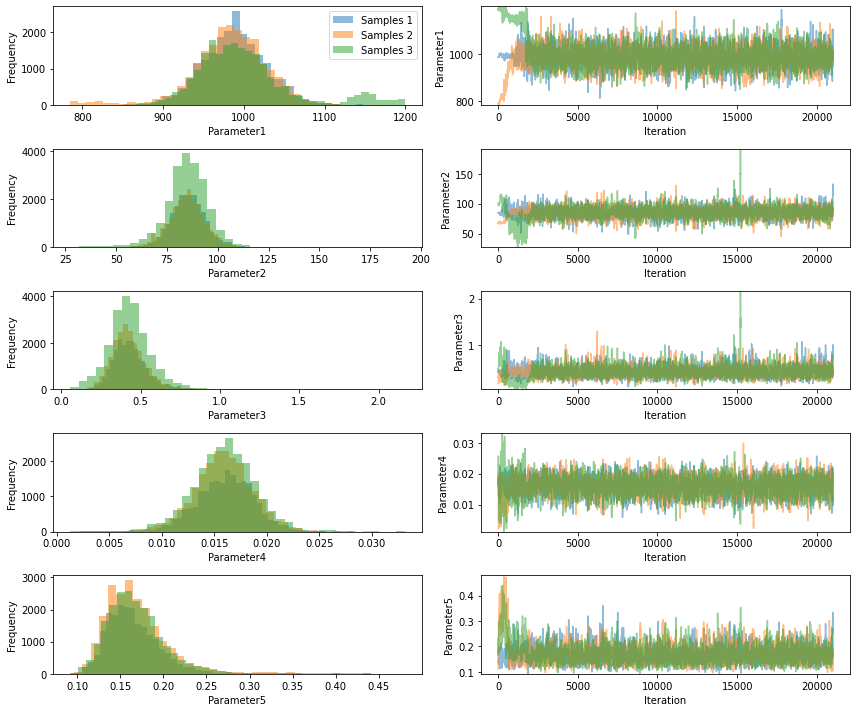

In [8]:
pints.plot.trace(samples)
plt.show()

### Model Comparison

Now we want to compare the different noise models and decide which best fits the data. The various ways of doing this require the posterier to be calculated for each time point and each set of parameters.

In [13]:
import numpy as np
# import math
# import matplotlib.pyplot as plt
# import scipy
# from scipy import optimize, integrate
import pints
# import pints.plot
import pandas
# import plotly.express as px
# import plotly.graph_objects as go
# import nbformat

# Get our Log-likelihoods:
from ipynb.fs.full.model_simulation import GaussianLogLikelihood
from ipynb.fs.full.model_simulation import MultiplicativeGaussianLogLikelihood
from ipynb.fs.full.model_simulation import ConstantAndMultiplicativeGaussianLogLikelihood

In [14]:
data_type = 'real'
model_type = 'multNoEta'
drug = 'Docetaxel'
observation = 'Platelets '
dose = 10
num_comp = 2

# Load data
df = pandas.read_csv("0470-2008_2018-05-09.csv")
df = df.sort_values(['DOSE', 'TIME'], ascending=True)
df = df.astype({'ID': 'int64'})
df_drug = df.loc[(df['DOSE'] == dose) & (df['DRUG'] == drug)] #
df_OBS = df_drug.loc[(df_drug['YNAME'] == observation)]
df_OBS = df_OBS.drop(df_OBS[df_OBS['OBS'] == '.'].index)[['TIME', 'DOSE', 'OBS']]
df_OBS = df_OBS.astype({'OBS': 'float64'})
df_stats = df_OBS[['TIME', 'DOSE', 'OBS']]
df_stats = df_stats.astype({'OBS': 'float64'})
df_stats = df_stats.groupby(["TIME", "DOSE"], as_index=False).filter(lambda x: len(x) > 1).groupby(["TIME", "DOSE"], as_index=False).agg({'OBS':['mean','std']})
df_stats.columns = ['TIME', "DOSE", 'mean', 'std']

# Load samples
samples = np.load("./Data_and_parameters/pd_"+data_type+"_mcmc_"+model_type+"_params_dose_"+str(dose)+".npy")
print(samples.shape)

(3, 21000, 5)


In [15]:
from ipynb.fs.full.model_simulation import PintsPDFriberg # import the pints model

# Create the model in PINTS
PK_params=np.load('PK_parameters_real_'+drug+str(dose)+'.npy')
start_time = df_OBS['TIME'].min()
print(start_time)

pints_model_real = PintsPDFriberg(PK_params, dose, num_comp=num_comp, start_time=start_time)
problem = pints.SingleOutputProblem(pints_model_real, np.asarray(df_stats['TIME'])-start_time, df_stats['mean'])
    

-48.0


In [16]:
# Recreate
parameters = np.load("./Data_and_parameters/pd_"+data_type+"_opt_"+"combNoEta"+"_params_dose_"+str(dose)+".npy")

log_likelihood = GaussianLogLikelihood(problem)
test_likelihood = pints.GaussianLogLikelihood(problem)
num_iterations = (pints_model_real.n_parameters()+3)*3000

print(parameters)

[9.87182190e+02 8.42956640e+01 4.14055226e-01 1.65377881e-02
 1.48100237e-12 1.38470015e-01]


In [9]:
pointwise = []
sum_likelihoods = []

no_samples = samples.shape[1]
for chain_no, chain in enumerate(samples):
    proportion_check = 0
    for j, sample_parameters in enumerate(chain):
        single_pointwise = log_likelihood.create_pointwise_loglikelihoods(sample_parameters)
        pointwise.append(single_pointwise)
        test = test_likelihood.__call__(sample_parameters)
        sum_likelihoods.append(test)
        proportion = (j+1)/no_samples
        if proportion > proportion_check:
            print("chain "+str(chain_no+1)+"\t\t" +str(proportion_check*100)+"%")
            if proportion_check < 0.1:
                proportion_check += 0.01
            else:
                proportion_check += 0.1
pointwise = np.asarray(pointwise)

chain 1		0%
chain 1		1.0%
chain 1		2.0%
chain 1		3.0%
chain 1		4.0%
chain 1		5.0%
chain 1		6.000000000000001%
chain 1		7.000000000000001%
chain 1		8.0%
chain 1		9.0%
chain 1		10.0%
chain 1		10.999999999999998%
chain 1		21.0%
chain 1		31.0%
chain 1		41.0%
chain 1		51.0%
chain 1		61.0%
chain 1		71.0%
chain 1		81.0%
chain 1		90.99999999999999%
chain 2		0%
chain 2		1.0%
chain 2		2.0%
chain 2		3.0%
chain 2		4.0%
chain 2		5.0%
chain 2		6.000000000000001%
chain 2		7.000000000000001%
chain 2		8.0%
chain 2		9.0%
chain 2		10.0%
chain 2		10.999999999999998%
chain 2		21.0%
chain 2		31.0%
chain 2		41.0%
chain 2		51.0%
chain 2		61.0%
chain 2		71.0%
chain 2		81.0%
chain 2		90.99999999999999%
chain 3		0%
chain 3		1.0%
chain 3		2.0%
chain 3		3.0%
chain 3		4.0%
chain 3		5.0%
chain 3		6.000000000000001%
chain 3		7.000000000000001%
chain 3		8.0%
chain 3		9.0%
chain 3		10.0%
chain 3		10.999999999999998%
chain 3		21.0%
chain 3		31.0%
chain 3		41.0%
chain 3		51.0%
chain 3		61.0%
chain 3		71.0%
chain 3		81.0%

In [17]:
np.save("./Data_and_parameters/pd_"+data_type+"_mcmc_"+"add"+"_pointwiseLogLikelihoods_dose_"+str(dose)+".npy", pointwise)

NameError: name 'pointwise' is not defined

In [12]:
print(pointwise.shape)
sum_points = np.sum(pointwise, axis=1)
print(np.sum(sum_likelihoods-sum_points))

(63000, 20)
6.039626896381378e-07


### Using Arvix to analyse results

In [79]:
import arviz as az
import matplotlib.pyplot as plt

model_type = "add"

samples = np.load("./Data_and_parameters/pd_"+data_type+"_mcmc_"+model_type+"_params_dose_"+str(dose)+".npy")
pointwise =np.load("./Data_and_parameters/pd_"+data_type+"_mcmc_"+model_type+"_pointwiseLogLikelihoods_dose_"+str(dose)+".npy")
pointwise=[pointwise[:21000,:],pointwise[21000:42000,:],pointwise[42000:,:]]
pointwise= np.asarray(pointwise)
print(pointwise.shape)

(3, 21000, 20)


In [80]:
likelihood = az.convert_to_inference_data(pointwise, group='log_likelihood')
posterior = az.convert_to_inference_data(samples, group='posterior')
observed = az.convert_to_inference_data(np.asarray(df_stats['mean']), group='observed_data')

inference_data = az.concat(likelihood, posterior, observed)
print(model_type)
# print(inference_data)
# print(inference_data.observed_data)
print(az.loo(inference_data))

add
Computed from 63000 by 20 log-likelihood matrix

         Estimate       SE
elpd_loo -683636579566717558238123917312.00  165749805732667883592527904768.00
p_loo    683636579566717558238123917312.00        -

There has been a warning during the calculation. Please check the results.


/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


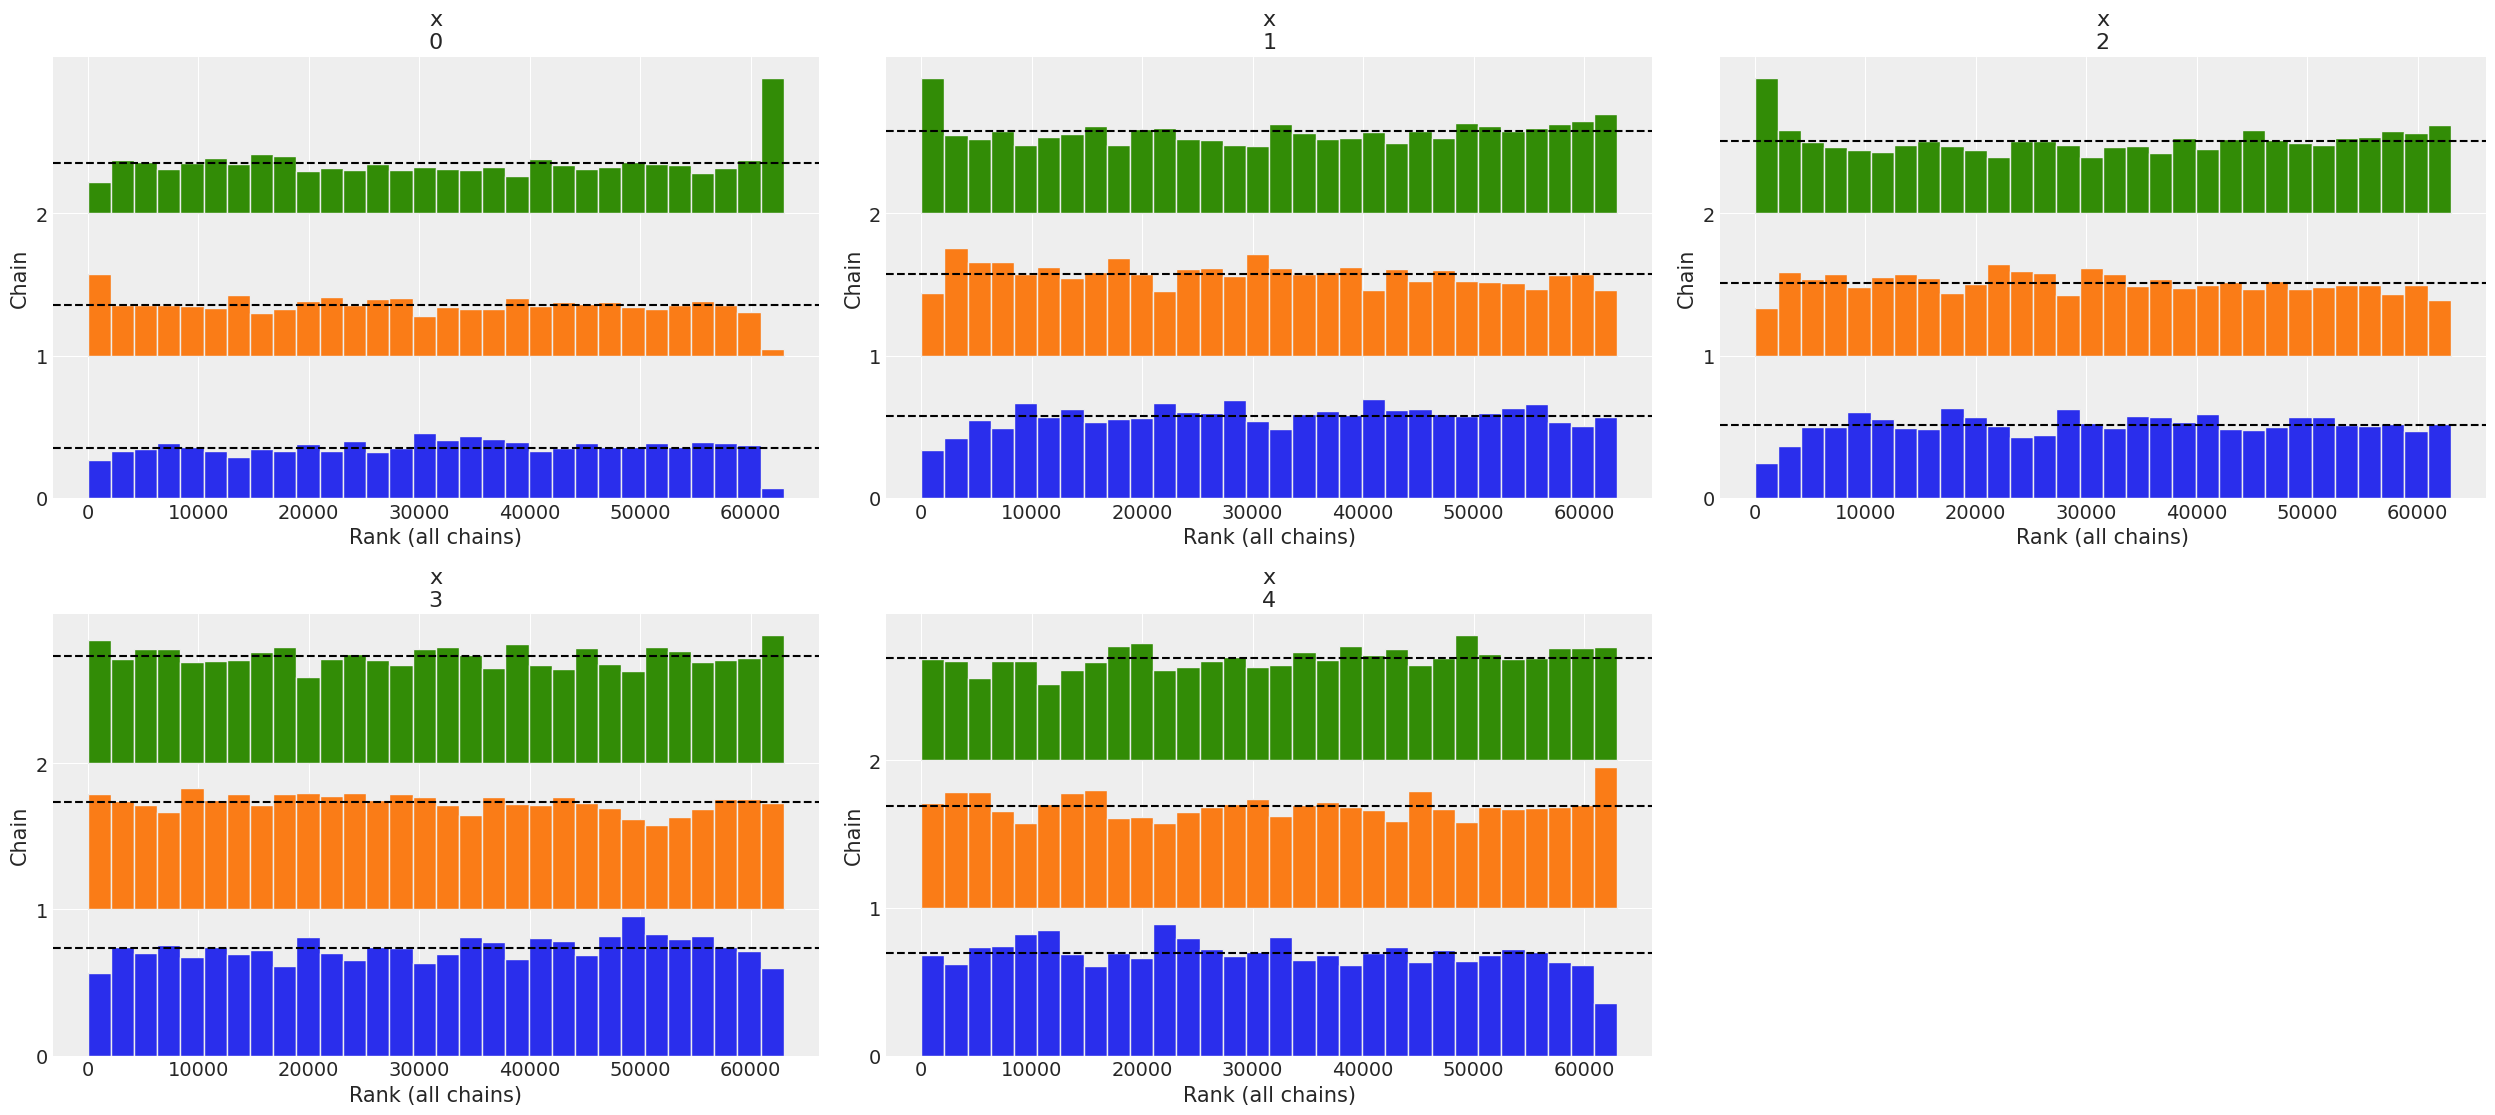

In [23]:
parameter_names = ['Circ_0', 'MTT', 'gamma', 'slope', 'sigma_base', 'eta', 'sigma_rel']
n_param = 5

az.style.use("arviz-darkgrid")
var_names=parameter_names[:n_param]

# az.plot_autocorr(inference_data)
# plt.show()

# az.plot_ess(inference_data, kind="evolution")
# plt.show()

# loo = az.loo(inference_data, pointwise=True)
# az.plot_khat(loo, show_bins=True)
# plt.show()

az.plot_rank(inference_data)
plt.show()

# az.plot_loo_pit(inference_data, y="0", ecdf=True, color="maroon")
# plt.show()

# Needs posterior predictive

# az.plot_bpv(inference_data)
# plt.show()
# az.plot_bpv(inference_data, kind="t_stat", t_stat="0.5")
# plt.show()

# Needs sample_stats

# az.plot_energy(inference_data, figsize=(12, 8))
# plt.show()




#### Comparisons

In [82]:
model_types = ["combNoEta", "add", "multNoEta"]
compare_dict = {}

for model_type in model_types:
    samples = np.load("./Data_and_parameters/pd_"+data_type+"_mcmc_"+model_type+"_params_dose_"+str(dose)+".npy")
    pointwise =np.load("./Data_and_parameters/pd_"+data_type+"_mcmc_"+model_type+"_pointwiseLogLikelihoods_dose_"+str(dose)+".npy")
    pointwise=[pointwise[:21000,:],pointwise[21000:42000,:],pointwise[42000:,:]]
    pointwise= np.asarray(pointwise)
    likelihood = az.convert_to_inference_data(pointwise, group='log_likelihood')
    posterior = az.convert_to_inference_data(samples, group='posterior')
    observed = az.convert_to_inference_data(np.asarray(df_stats['mean']), group='observed_data')
    inference_data = az.concat(likelihood, posterior, observed)
    compare_dict[model_type] = inference_data
    print(model_type)
    # print(inference_data)
    print(inference_data.posterior)
    # print(az.loo(inference_data))

comparison = az.compare(compare_dict)
comparison

combNoEta
<xarray.Dataset>
Dimensions:  (chain: 3, draw: 21000, x_dim_0: 6)
Coordinates:
  * chain    (chain) int64 0 1 2
  * draw     (draw) int64 0 1 2 3 4 5 6 ... 20994 20995 20996 20997 20998 20999
  * x_dim_0  (x_dim_0) int64 0 1 2 3 4 5
Data variables:
    x        (chain, draw, x_dim_0) float64 987.2 84.3 0.4141 ... 40.35 0.1164
Attributes:
    created_at:     2021-03-22T15:04:54.837628
    arviz_version:  0.11.2
add
<xarray.Dataset>
Dimensions:  (chain: 3, draw: 21000, x_dim_0: 5)
Coordinates:
  * chain    (chain) int64 0 1 2
  * draw     (draw) int64 0 1 2 3 4 5 6 ... 20994 20995 20996 20997 20998 20999
  * x_dim_0  (x_dim_0) int64 0 1 2 3 4
Data variables:
    x        (chain, draw, x_dim_0) float64 987.2 84.3 0.4141 ... 12.0 0.0008952
Attributes:
    created_at:     2021-03-22T15:04:54.856507
    arviz_version:  0.11.2
multNoEta
<xarray.Dataset>
Dimensions:  (chain: 3, draw: 21000, x_dim_0: 5)
Coordinates:
  * chain    (chain) int64 0 1 2
  * draw     (draw) int64 0 1 2 3 4 

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance 

rank           loo         p_loo         d_loo        weight  \
combNoEta     0 -9.506079e+01  4.235018e+00  0.000000e+00  1.000000e+00   
multNoEta     1 -1.318854e+02  4.398985e+00  3.682460e+01  0.000000e+00   
add           2 -6.836366e+29  6.836366e+29  6.836366e+29  6.631806e-12   

                     se           dse  warning loo_scale  
combNoEta  2.765604e+00  0.000000e+00     True       log  
multNoEta  2.864171e+00  2.539391e-01     True       log  
add        1.657498e+29  1.657498e+29     True       log

In [71]:
model_type = "multNoEta"
z_value = comparison["d_loo"][model_type] / comparison["dse"][model_type]
p_value = scipy.stats.norm.sf(abs(z_value))
print(model_type)
print("\t z value =", z_value)
print("\t p value =", p_value)

model_type = "add"
z_value = comparison["d_loo"][model_type] / comparison["dse"][model_type]
p_value = scipy.stats.norm.sf(abs(z_value))
print(model_type)
print("\t z value =", z_value)
print("\t p value =", p_value)

multNoEta
	 z value = 145.0135084348868
	 p value = 0.0
add
	 z value = 4.124509084911576
	 p value = 1.8576316426314295e-05


In [65]:
comparison = az.compare(compare_dict, ic="waic")
comparison

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.

rank          waic        p_waic        d_waic        weight  \
combNoEta     0 -9.459548e+01  3.769708e+00  0.000000e+00  1.000000e+00   
multNoEta     1 -1.313813e+02  3.894887e+00  3.678582e+01  0.000000e+00   
add           2 -2.434745e+54  2.434745e+54  2.434745e+54  1.800116e-12   

                     se           dse  warning waic_scale  
combNoEta  2.646156e+00  0.000000e+00     True        log  
multNoEta  2.685906e+00  2.268053e-01     True        log  
add        1.036791e+54  1.036791e+54     True        log

In [68]:
model_type = "multNoEta"
z_value = comparison["d_waic"][model_type] / comparison["dse"][model_type]
p_value = scipy.stats.norm.sf(abs(z_value))
print(model_type)
print("\t z value =", z_value)
print("\t p value =", p_value)

model_type = "add"
z_value = comparison["d_waic"][model_type] / comparison["dse"][model_type]
p_value = scipy.stats.norm.sf(abs(z_value))
print(model_type)
print("\t z value =", z_value)
print("\t p value =", p_value)

multNoEta
	 z value = 162.1911744652855
	 p value = 0.0
add
	 z value = 2.348347874194466
	 p value = 0.009428450172006612
